In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv
/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv
/kaggle/input/rohlik-orders-forecasting-challenge/train.csv
/kaggle/input/rohlik-orders-forecasting-challenge/test.csv
/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta, date 
import statsmodels.api as sm

In [66]:
train_data=pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/train.csv")
test_data=pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/test.csv")
train_calender=pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv")
test_calender=pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv")


#### What are the columns in train data?

In [67]:
train_data.dtypes,train_data.shape

(warehouse                  object
 date                       object
 orders                    float64
 holiday_name               object
 holiday                     int64
 shutdown                    int64
 mini_shutdown               int64
 shops_closed                int64
 winter_school_holidays      int64
 school_holidays             int64
 blackout                    int64
 mov_change                float64
 frankfurt_shutdown          int64
 precipitation             float64
 snow                      float64
 user_activity_1           float64
 user_activity_2           float64
 id                         object
 dtype: object,
 (7340, 18))

#### what is/are primary key in data?
id is the primary key. It is a combination of warehouse_name and date
#### Is there any duplicate records?
No duplicate records


In [68]:
print(train_data["id"].shape)
train_data.id.duplicated().sum()


(7340,)


0

#### Null column check

In [69]:
for column in train_data.columns:
    print(f" Number of null values in {column} : {train_data[column].isnull().sum()}")

 Number of null values in warehouse : 0
 Number of null values in date : 0
 Number of null values in orders : 0
 Number of null values in holiday_name : 7122
 Number of null values in holiday : 0
 Number of null values in shutdown : 0
 Number of null values in mini_shutdown : 0
 Number of null values in shops_closed : 0
 Number of null values in winter_school_holidays : 0
 Number of null values in school_holidays : 0
 Number of null values in blackout : 0
 Number of null values in mov_change : 0
 Number of null values in frankfurt_shutdown : 0
 Number of null values in precipitation : 270
 Number of null values in snow : 270
 Number of null values in user_activity_1 : 0
 Number of null values in user_activity_2 : 0
 Number of null values in id : 0


In [70]:
for column in train_data.columns:
    if train_data[column].nunique()<10:
        print(f"Unique values in {column}:\n{train_data[column].unique()}")

Unique values in warehouse:
['Prague_1' 'Brno_1' 'Prague_2' 'Prague_3' 'Munich_1' 'Frankfurt_1'
 'Budapest_1']
Unique values in holiday:
[0 1]
Unique values in shutdown:
[0 1]
Unique values in mini_shutdown:
[0 1]
Unique values in shops_closed:
[0 1]
Unique values in winter_school_holidays:
[0 1]
Unique values in school_holidays:
[0 1]
Unique values in blackout:
[0 1]
Unique values in mov_change:
[0.  1.  0.7]
Unique values in frankfurt_shutdown:
[0 1]


### Analyse different warehouses

- we have 7 different ware houses, each warehouse  might have different realations, let's explore that

##### 1. Does how does the trend looks like in each warehouse?

- Prague_1 and Brno is almost same
- Prague_1 and Prague_1 and Budapest_1 has same trend 

- Frankfurt_1 and Munich_1 are comparatively new warehouses

##### 2.Is the working days for all warehouses are same?
- excpet for Frankfurt_1 all other warehouse operates 7 days in week

##### 3. Is there any missing dates between the start and end date

- Munich_1 ,frankfurt_1 and Budapest_1 are closed on holidays and will open 

##### 4.why did munich openned on 3 days in july 2023
- No explanation found , so if we are going to use week day as a variable then remove those three days from training

##### 5. Seasonality of data, weekly, monthly, yearly. Separetly investigate for each warehouse.
-Weekly :
  - There is a weekly seasonality ,first day of the year is different from rest.Neet to investgate more on outliers.
- Monthly
  - No monthly seaonality
-Yearly
   - yes there is yearly seasonality, 
   - Q: should remove weekly seasonality to extract yearly seasonality, or keep it


##### 6. Ideally we should have equal or one less count each of the week days. But there can be some missing days because of holidays and closures. Lets investigate on all missing work days.



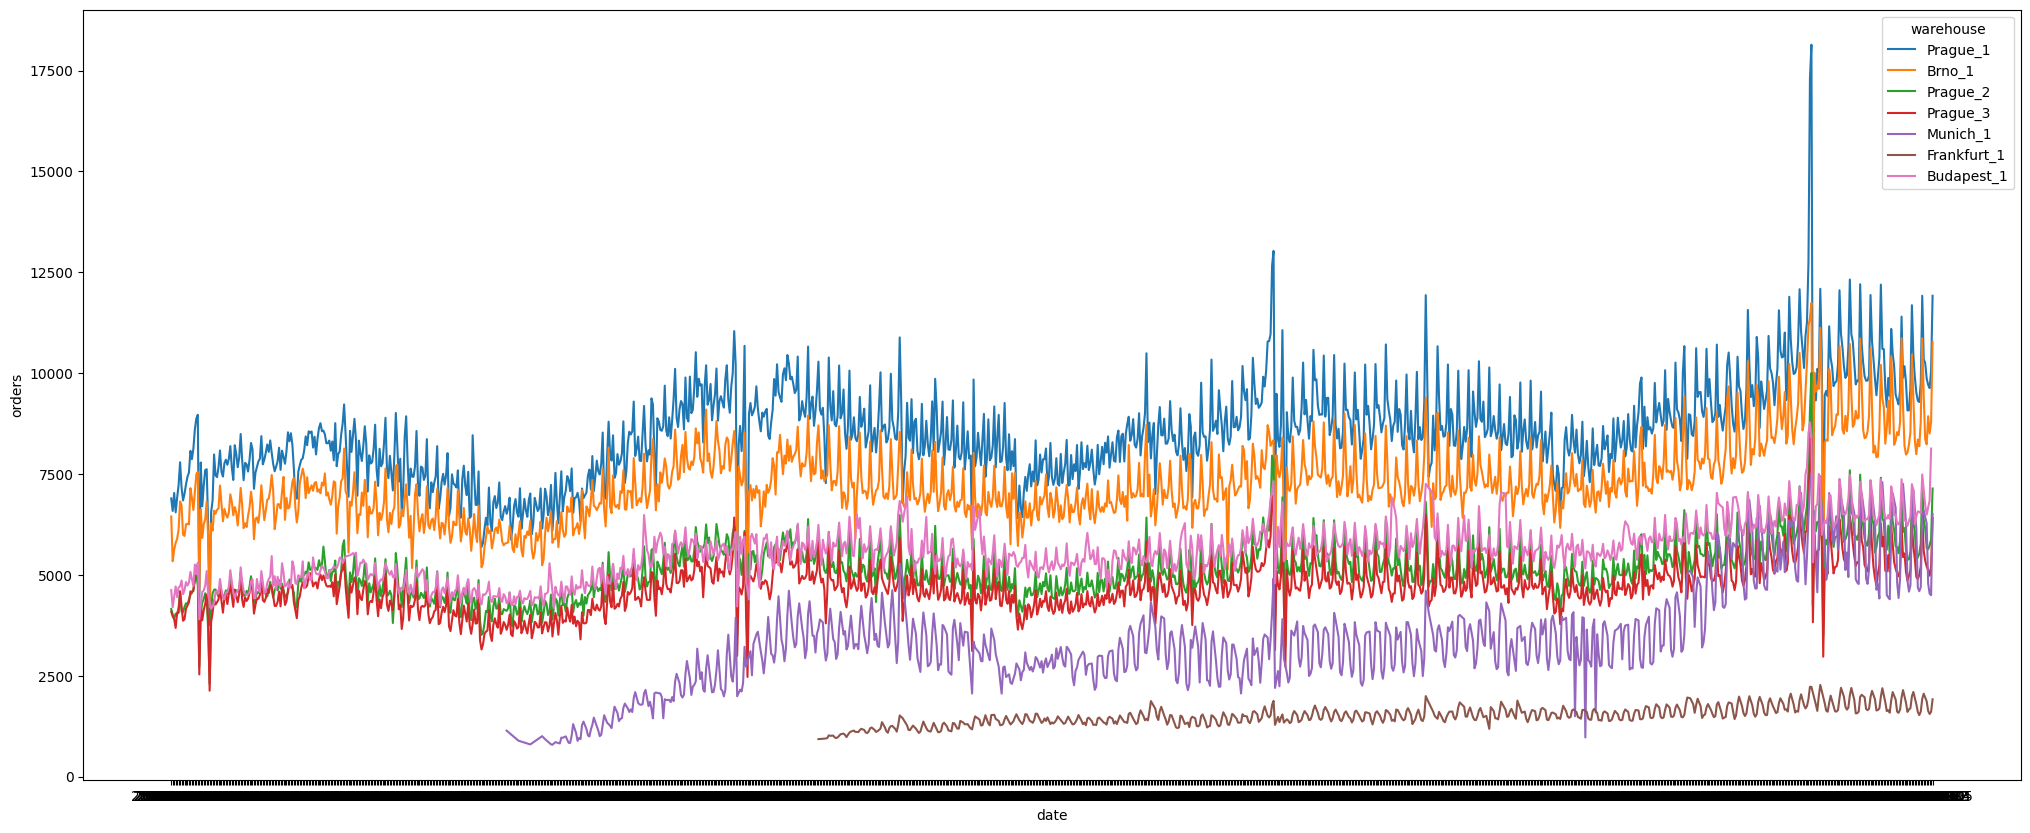

In [71]:
### Trend in oreders

fig, ax = plt.subplots(figsize=(25, 10))
sns.lineplot(train_data,x='date',y='orders',hue='warehouse',ax=ax)
plt.show()

In [72]:
train_data["date"]=pd.to_datetime(train_data['date'])
train_data['month']=train_data['date'].dt.month
train_data["day_of_week"] =train_data["date"].dt.weekday
for warehouse in train_data.warehouse.unique():
    df=train_data[train_data.warehouse==warehouse]
    print(f"{warehouse}: {df.day_of_week.unique()}")

Prague_1: [5 6 0 1 2 3 4]
Brno_1: [5 6 0 1 2 3 4]
Prague_2: [5 6 0 1 2 3 4]
Prague_3: [5 6 0 1 2 3 4]
Munich_1: [2 3 4 5 0 1 6]
Frankfurt_1: [4 5 2 3 0 1]
Budapest_1: [5 6 0 1 2 3 4]


In [73]:
for warehouse in train_data.warehouse.unique():
    df=train_data[train_data.warehouse==warehouse]
    df["next_day"]=df.date.shift(1)
    df["difference"]=df["date"]-df["next_day"]
    #print(df.head)
    df_missing_date=df[df["difference"]>timedelta(days = 1)]
    print(df_missing_date.shape)
    df_missing_date["missing_date"]=df_missing_date["date"] + timedelta(days = 1)
    df_missing_date["missing_date_day"]=df_missing_date["missing_date"].dt.weekday
    col=["missing_date","missing_date_day"]
    print(warehouse)
    print( df['day_of_week'].value_counts())

(4, 22)
Prague_1
day_of_week
1    171
2    171
3    171
5    170
6    170
0    170
4    170
Name: count, dtype: int64
(4, 22)
Brno_1
day_of_week
1    171
2    171
3    171
5    170
6    170
0    170
4    170
Name: count, dtype: int64
(4, 22)
Prague_2
day_of_week
1    171
2    171
3    171
5    170
6    170
0    170
4    170
Name: count, dtype: int64
(4, 22)
Prague_3
day_of_week
1    171
2    171
3    171
5    170
6    170
0    170
4    170
Name: count, dtype: int64
(149, 22)
Munich_1
day_of_week
4    134
2    133
5    132
3    130
1    129
0    124
6      3
Name: count, dtype: int64
(116, 22)
Frankfurt_1
day_of_week
5    108
2    108
4    107
3    104
1    104
0     98
Name: count, dtype: int64
(32, 22)
Budapest_1
day_of_week
3    171
2    169
1    168
5    165
4    164
6    159
0    158
Name: count, dtype: int64


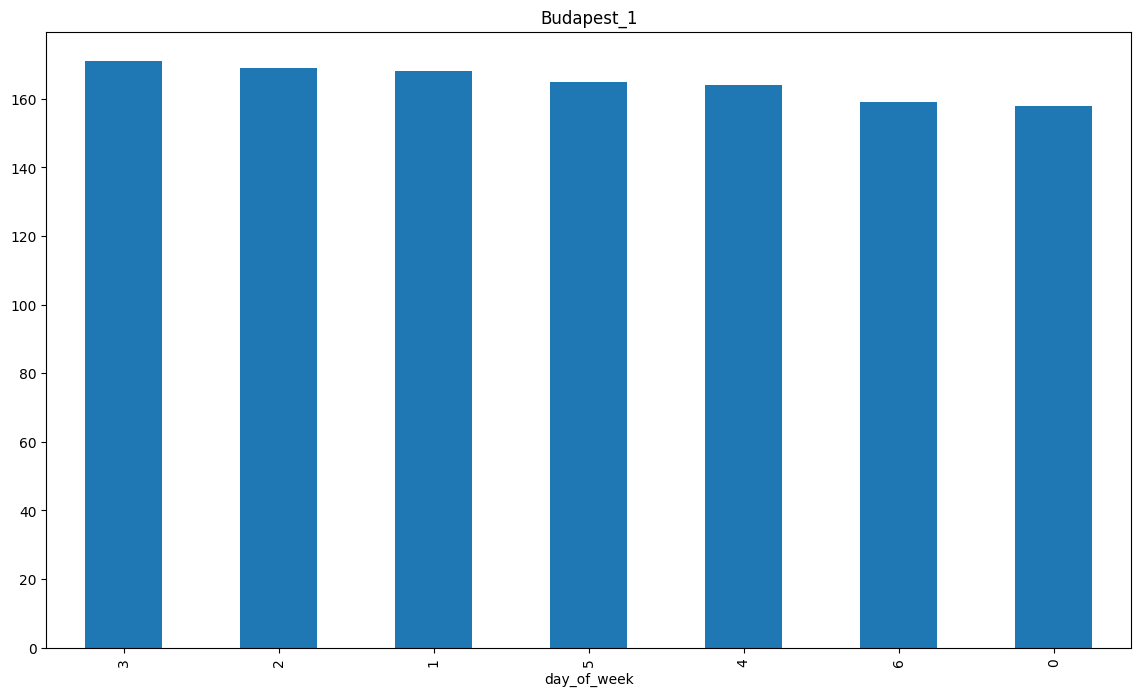

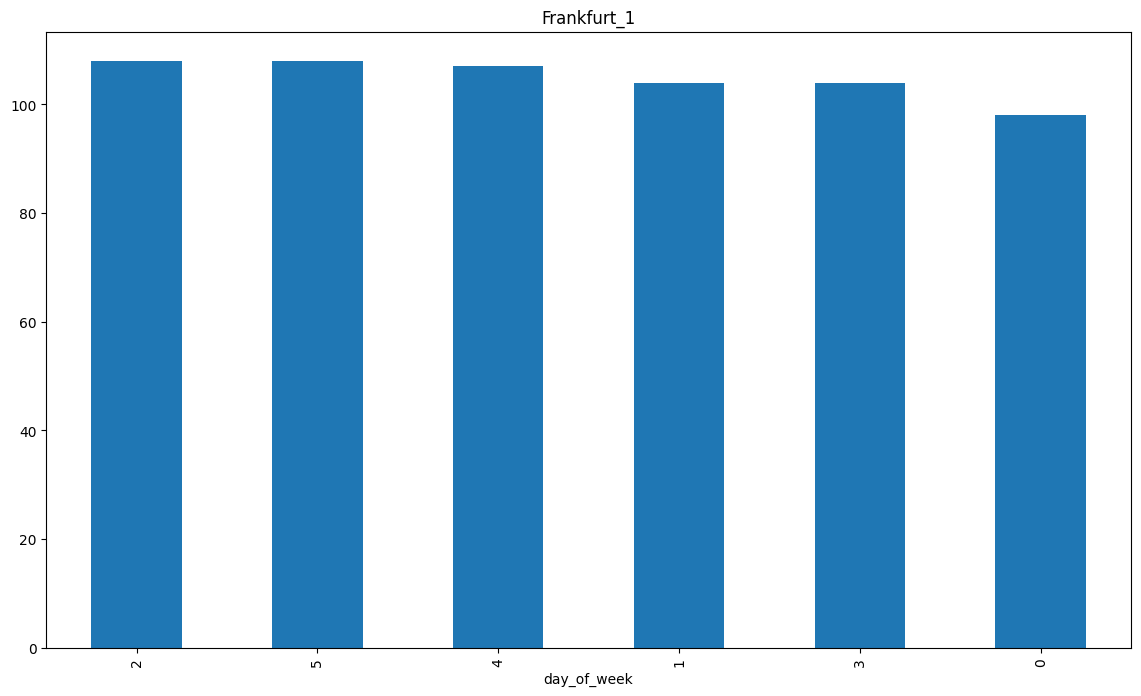

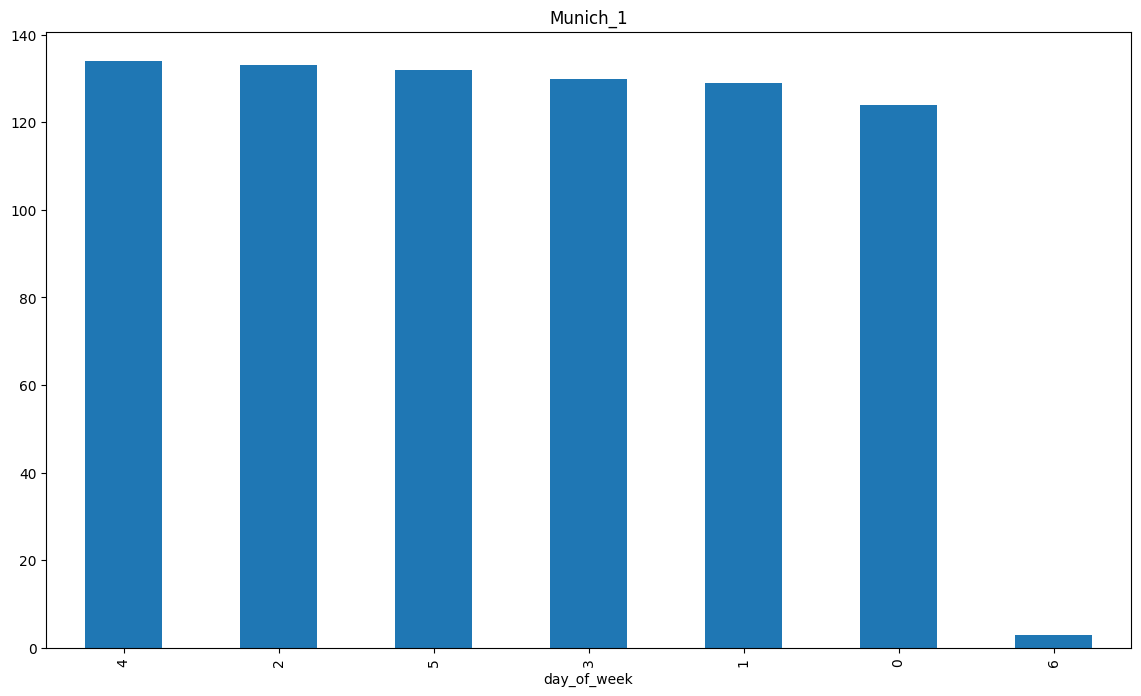

In [74]:
missing_dates_warehouse=["Budapest_1","Frankfurt_1","Munich_1"]
for warehouse in missing_dates_warehouse:
    df=train_data[train_data.warehouse==warehouse].sort_values(by='day_of_week')
   
    df['day_of_week'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title=warehouse)
    plt.show()

### For munich what is the order values if day==6


In [75]:
df=train_data[train_data.warehouse=='Munich_1']
print(df[df['day_of_week']==6])
df['date'].min(),df.date.max()

     warehouse       date  orders holiday_name  holiday  shutdown  \
5352  Munich_1 2023-07-16  1493.0          NaN        0         0   
5359  Munich_1 2023-07-23   970.0          NaN        0         0   
5366  Munich_1 2023-07-30  1590.0          NaN        0         0   

      mini_shutdown  shops_closed  winter_school_holidays  school_holidays  \
5352              0             0                       0                0   
5359              0             0                       0                0   
5366              0             0                       0                0   

      blackout  mov_change  frankfurt_shutdown  precipitation  snow  \
5352         0         0.0                   0           8.06   0.0   
5359         0         0.0                   0           0.00   0.0   
5366         0         0.0                   0           3.60   0.0   

      user_activity_1  user_activity_2                   id  month  \
5352            544.0          16884.0  Munich_1_2023-0

(Timestamp('2021-07-21 00:00:00'), Timestamp('2024-03-15 00:00:00'))

In [76]:
#### why did munich openned on 3 days in july 2023
df['month']=df['date'].dt.month
df['year']=df['date'].dt.year
df[(df['month']==7)&(df['year']==2023)]

warehouse       date  orders holiday_name  holiday  shutdown  \
5339  Munich_1 2023-07-01  3992.0          NaN        0         0   
5340  Munich_1 2023-07-03  3552.0          NaN        0         0   
5341  Munich_1 2023-07-04  2981.0          NaN        0         0   
5342  Munich_1 2023-07-05  2784.0          NaN        0         0   
5343  Munich_1 2023-07-06  2875.0          NaN        0         0   
5344  Munich_1 2023-07-07  3974.0          NaN        0         0   
5345  Munich_1 2023-07-08  3878.0          NaN        0         0   
5346  Munich_1 2023-07-10  3936.0          NaN        0         0   
5347  Munich_1 2023-07-11  3118.0          NaN        0         0   
5348  Munich_1 2023-07-12  2917.0          NaN        0         0   
5349  Munich_1 2023-07-13  2885.0          NaN        0         0   
5350  Munich_1 2023-07-14  4013.0          NaN        0         0   
5351  Munich_1 2023-07-15  4075.0          NaN        0         0   
5352  Munich_1 2023-07-16  1493.0          NaN        0         0   
5353  Munich_1 2023-07-17  3461.0          NaN        0         0   
5354  Munich_1 2023-07-18  3029.0          NaN        0         0   
5355  Munich_1 2023-07-19  2755.0          NaN        0         0   
5356  Munich_1 2023-07-20  2891.0          NaN        0         0   
5357  Munich_1 2023-07-21  3949.0          NaN        0         0   
5358  Munich_1 2023-07-22  3930.0          NaN        0         0   
5359  Munich_1 2023-07-23   970.0          NaN        0         0   
5360  Munich_1 2023-07-24  3642.0          NaN        0         0   
5361  Munich_1 2023-07-25  2891.0          NaN        0         0   
5362  Munich_1 2023-07-26  2834.0          NaN        0         0   
5363  Munich_1 2023-07-27  2726.0          NaN        0         0   
5364  Munich_1 2023-07-28  3707.0          NaN        0         0   
5365  Munich_1 2023-07-29  3896.0          NaN        0         0   
5366  Munich_1 2023-07-30  1590.0          NaN        0         0   
5367  Munich_1 2023-07-31  3528.0          NaN        0         0   

      mini_shutdown  shops_closed  winter_school_holidays  school_holidays  \
5339              0             0                       0                0   
5340              0             0                       0                0   
5341              0             0                       0                0   
5342              0             0                       0                0   
5343              0             0                       0                0   
5344              0             0                       0                0   
5345              0             0                       0                0   
5346              0             0                       0                0   
5347              0             0                       0                0   
5348              0             0                       0                0   
5349              0             0                       0                0   
5350              0             0                       0                0   
5351              0             0                       0                0   
5352              0             0                       0                0   
5353              0             0                       0                0   
5354              0             0                       0                0   
5355              0             0                       0                0   
5356              0             0                       0                0   
5357              0             0                       0                0   
5358              0             0                       0                0   
5359              0             0                       0                0   
5360              0             0                       0                0   
5361              0             0                       0                0   
5362              0             0                       0     

In [77]:
## for seasonality  we need to pass the number working days in a week, 
### lets remove 3 sundays in munich_1
train_data = train_data.drop(train_data[(train_data.warehouse=="Munich_1")&(train_data.day_of_week==6)].index)

warehouse:Prague_1,week_day_count:7


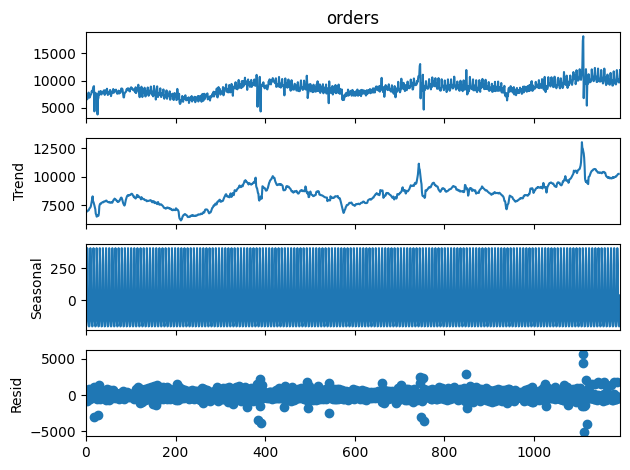

warehouse:Brno_1,week_day_count:7


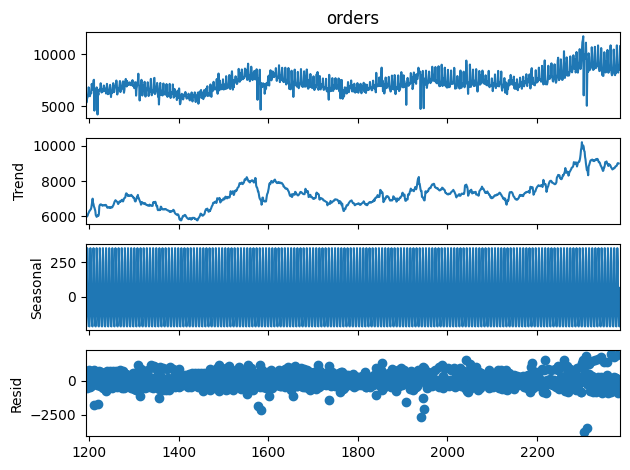

warehouse:Prague_2,week_day_count:7


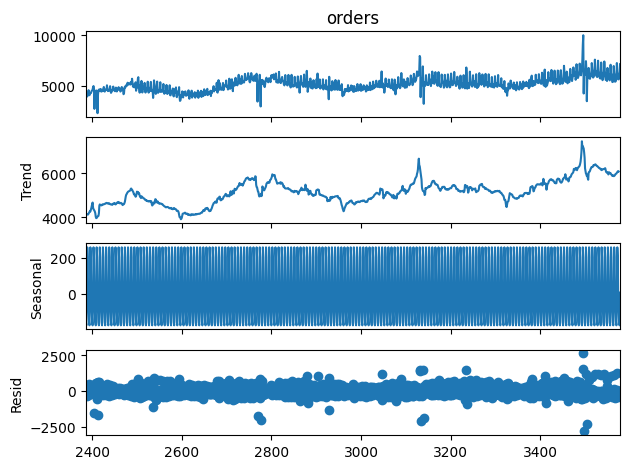

warehouse:Prague_3,week_day_count:7


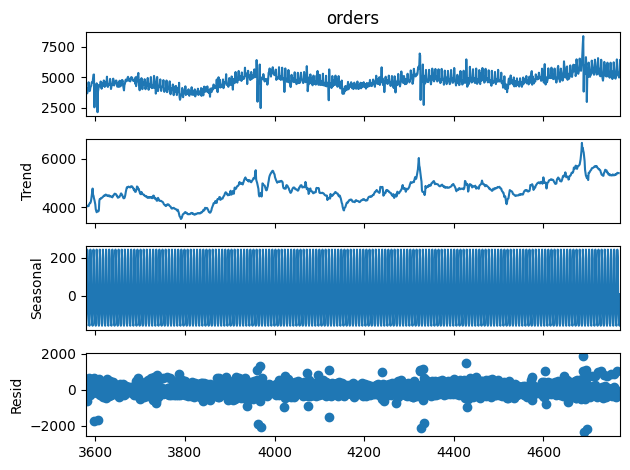

warehouse:Munich_1,week_day_count:6


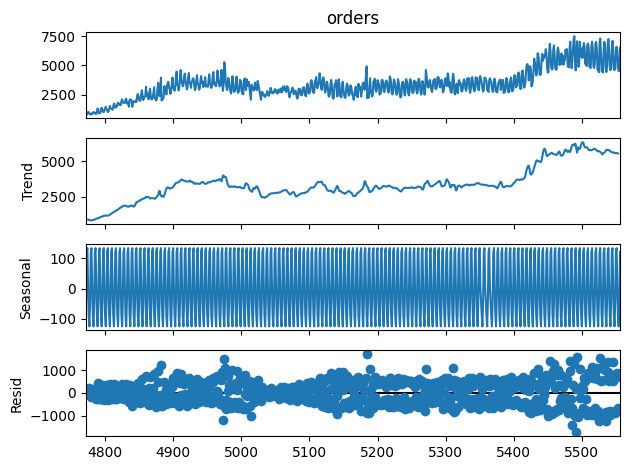

warehouse:Frankfurt_1,week_day_count:6


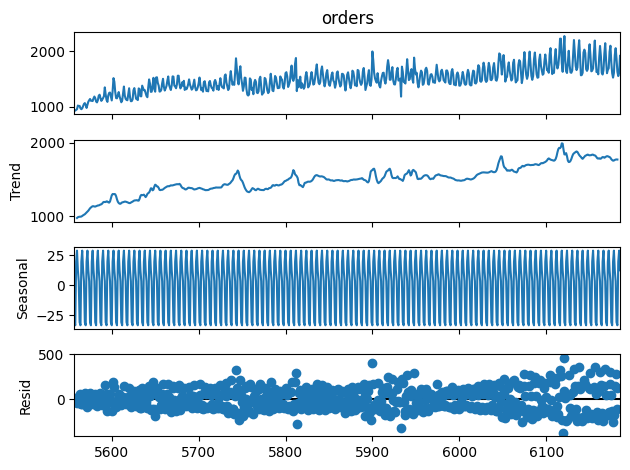

warehouse:Budapest_1,week_day_count:7


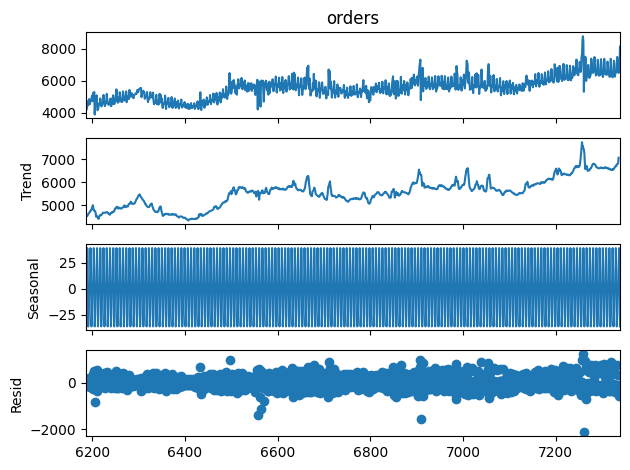

In [78]:
###  Seasonality 
### weekly 

for warehouse in train_data.warehouse.unique():
    df=train_data[train_data.warehouse==warehouse]
    week_day_count=df['day_of_week'].nunique()
    print(f"warehouse:{warehouse},week_day_count:{week_day_count}")
    res =sm.tsa.seasonal_decompose(df['orders'], period=week_day_count)
    
    fig = res.plot()
    plt.show()
   



    
    


Right now the residual values are very high meaning model is not seeing any perfect trend. But lets take a close look on data only with first few months 2024

warehouse:Prague_1,week_day_count:7


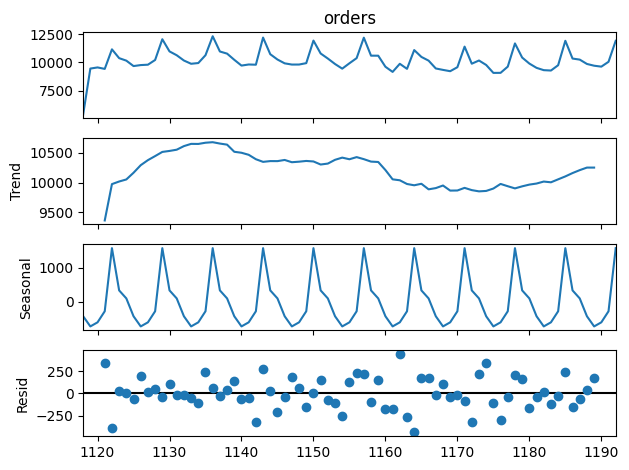

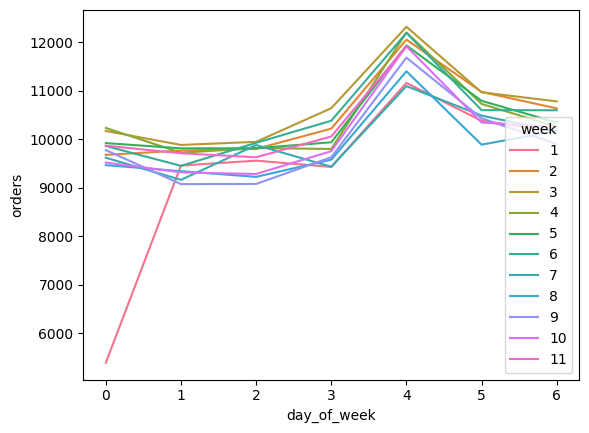

warehouse:Brno_1,week_day_count:7


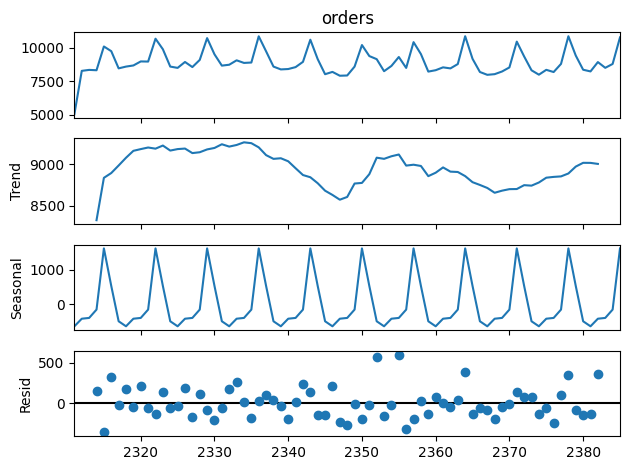

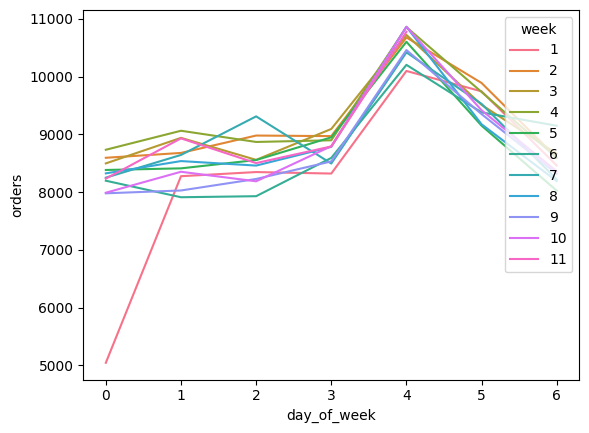

warehouse:Prague_2,week_day_count:7


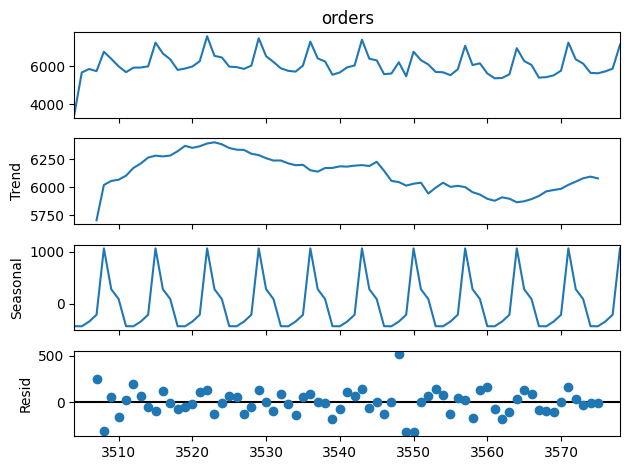

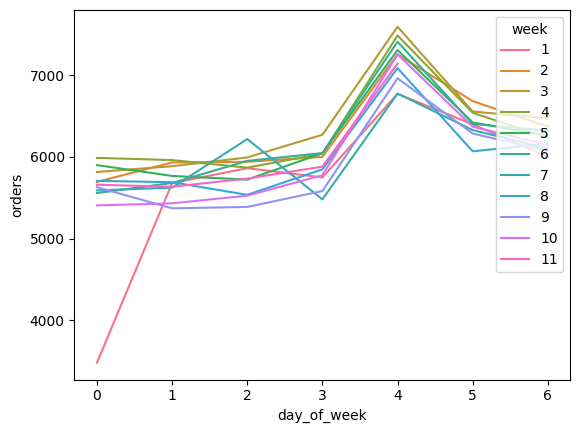

warehouse:Prague_3,week_day_count:7


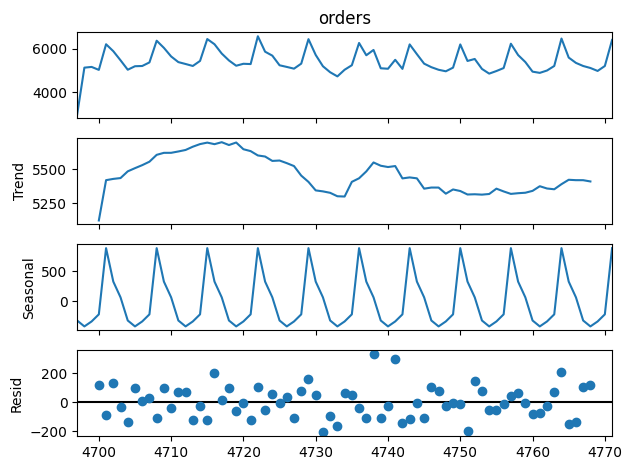

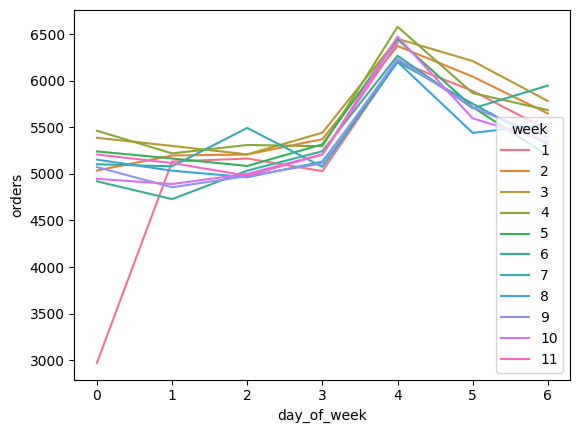

warehouse:Munich_1,week_day_count:6


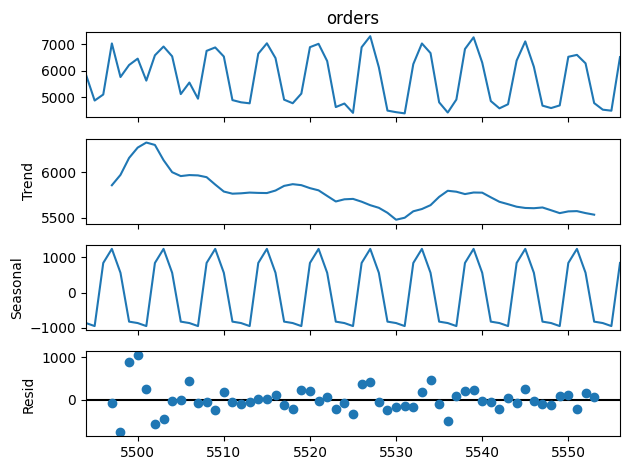

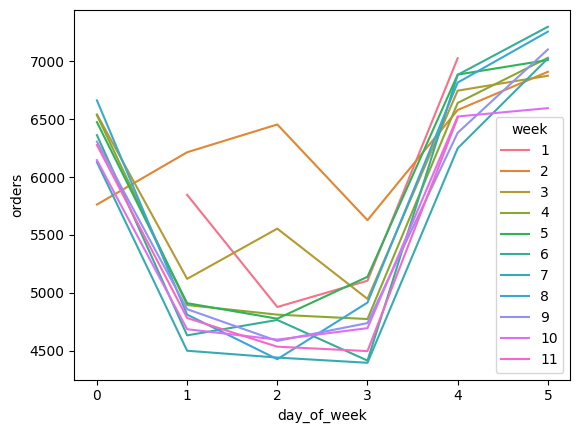

warehouse:Frankfurt_1,week_day_count:6


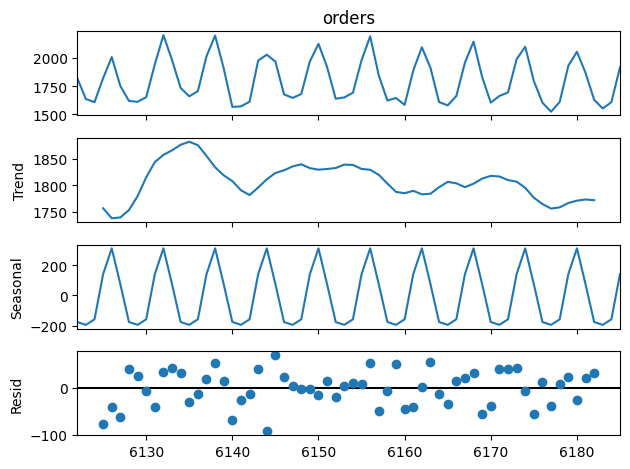

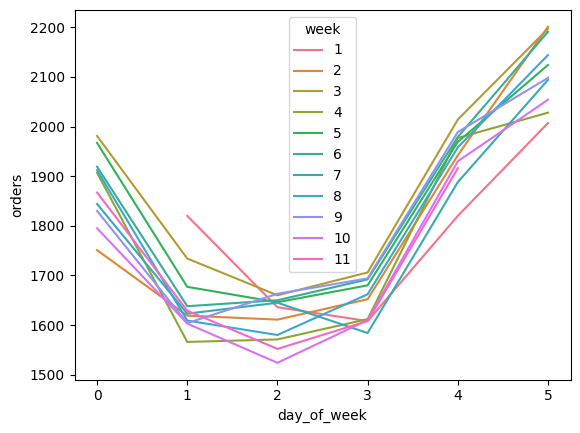

warehouse:Budapest_1,week_day_count:7


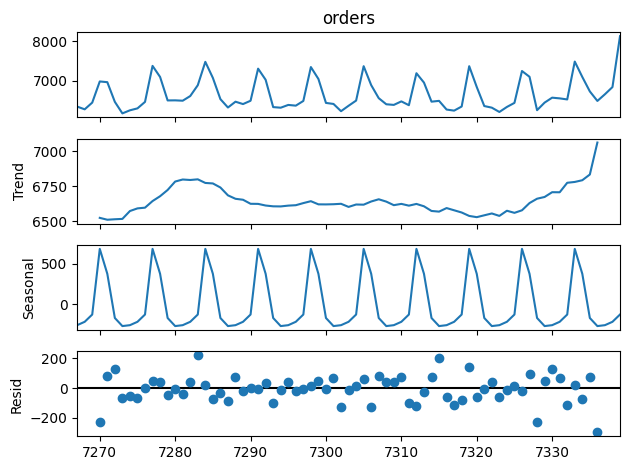

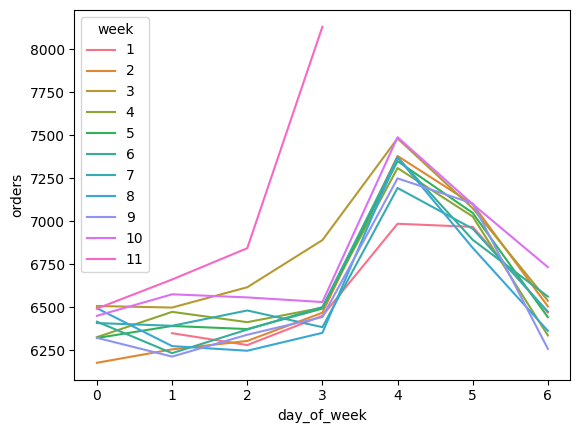

In [79]:
train_data['month']=train_data['date'].dt.month
train_data['year']=train_data['date'].dt.year
train_data["week"]=train_data['date'].dt.isocalendar().week
for warehouse in train_data.warehouse.unique():
    df=train_data[(train_data.warehouse==warehouse)&(train_data['year']==2024)]
    week_day_count=df['day_of_week'].nunique()
    print(f"warehouse:{warehouse},week_day_count:{week_day_count}")
    res =sm.tsa.seasonal_decompose(df['orders'], period=week_day_count)
    res.plot()
    plt.show()
    sns.lineplot(df,x='day_of_week',y='orders',hue=df['week'].astype(str))
    plt.show()

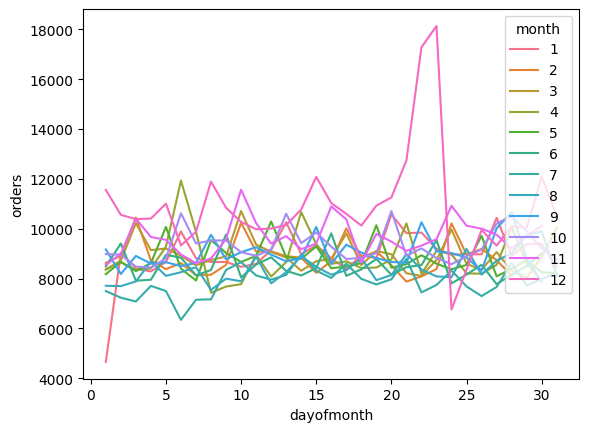

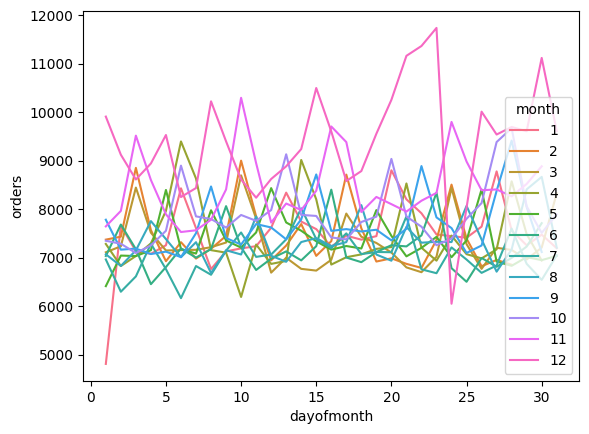

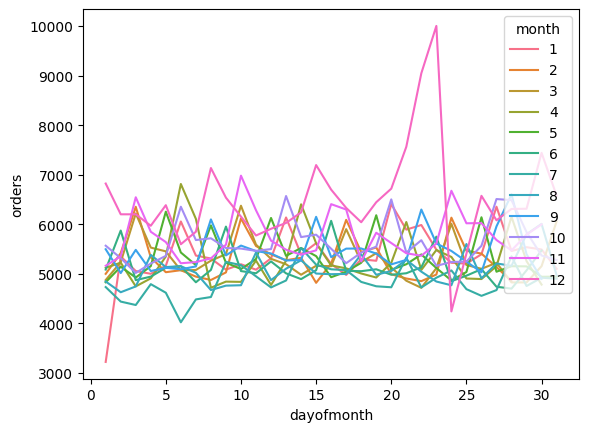

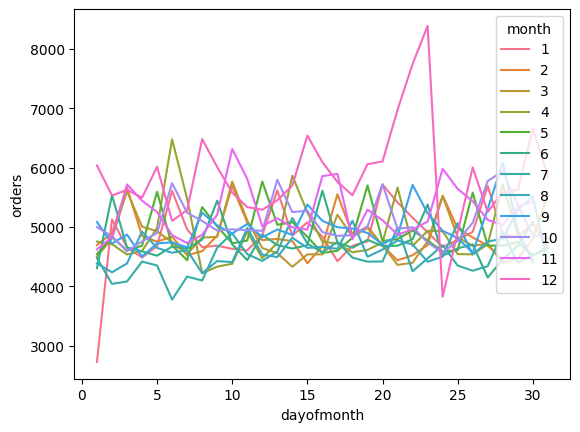

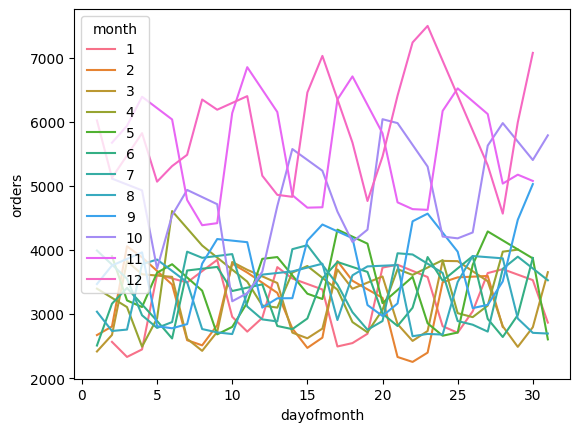

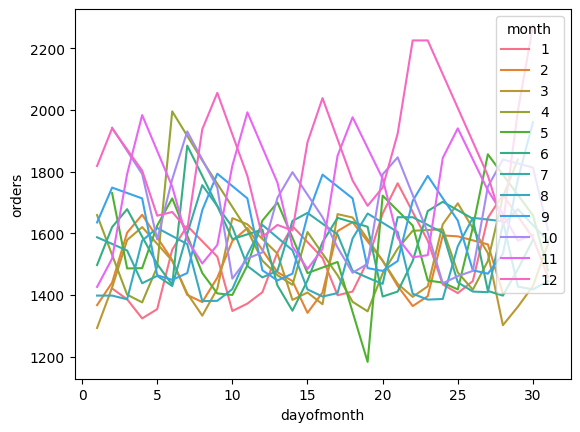

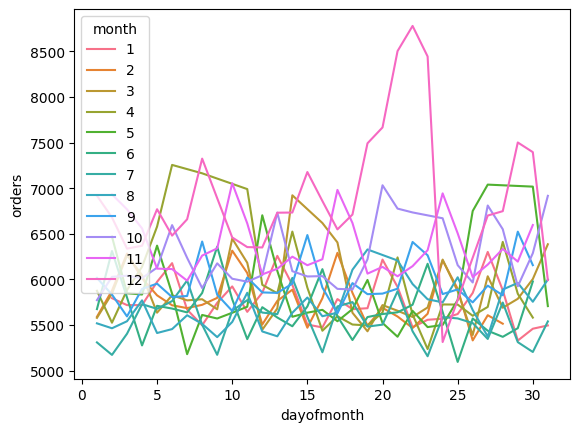

In [80]:
## Monthly
train_data["dayofmonth"]=train_data.date.dt.day
for warehouse in train_data.warehouse.unique():
    df=train_data[(train_data.warehouse==warehouse)&(train_data['year']==2023)]
  
    sns.lineplot(df,x='dayofmonth',y='orders',hue=df['month'].astype(str))
    plt.show()

 No monthly seasonality

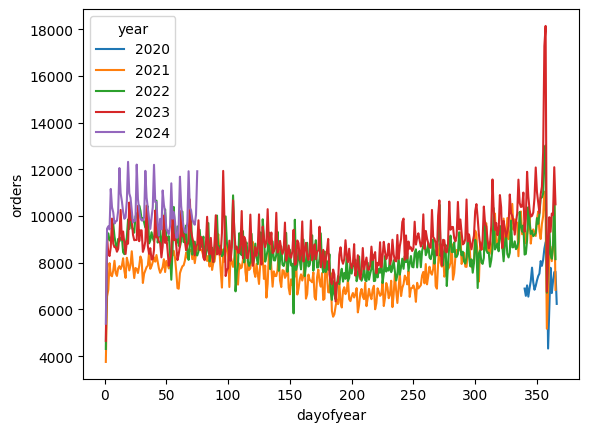

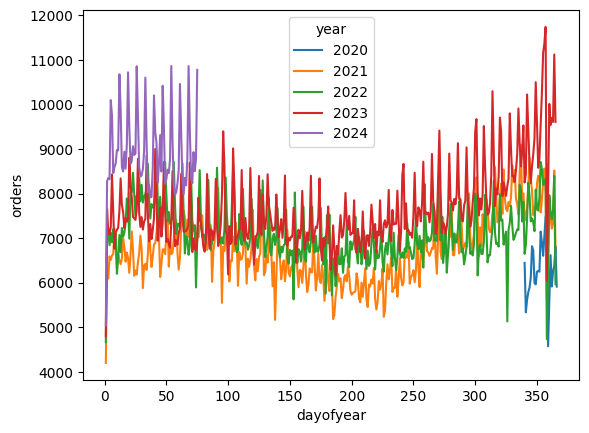

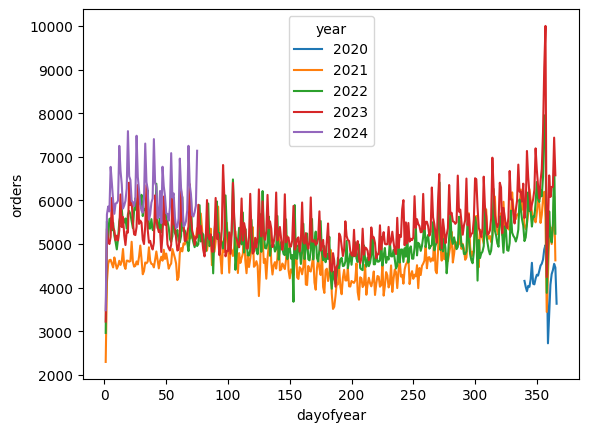

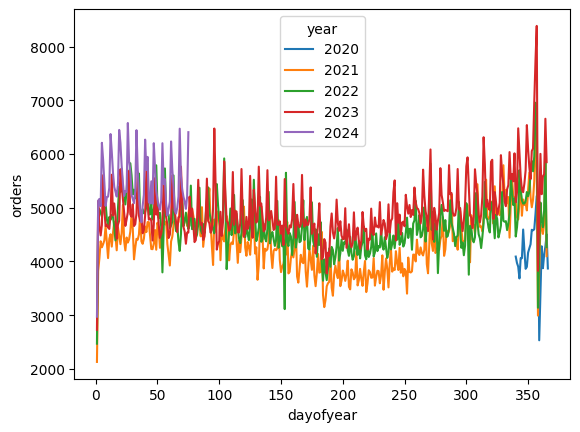

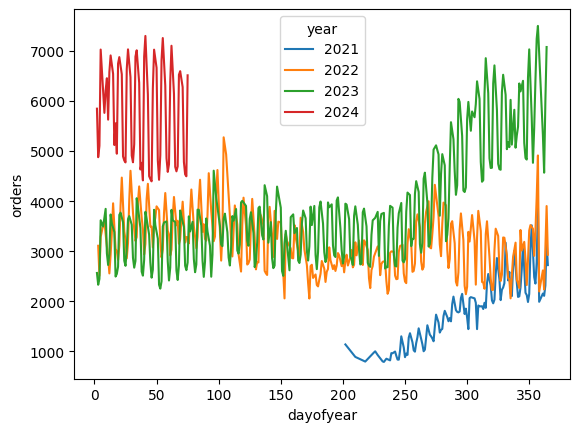

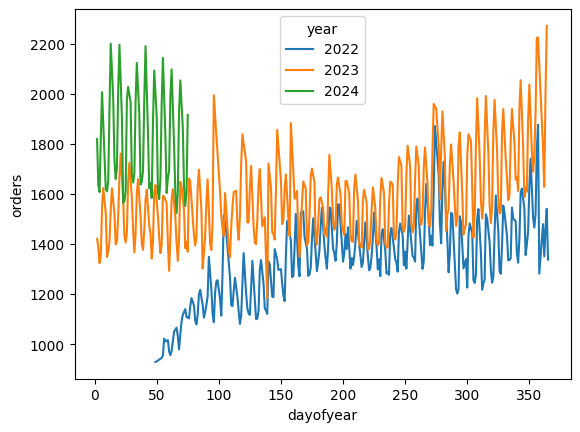

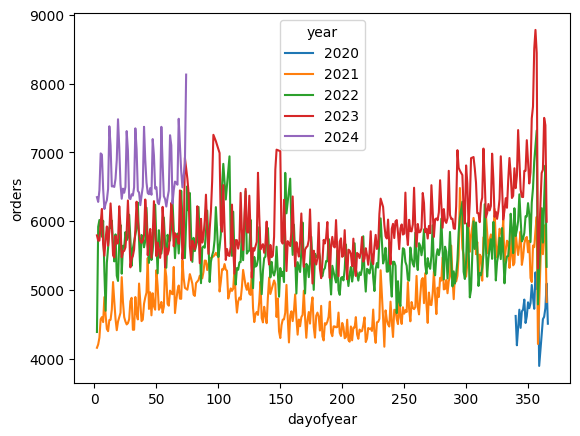

In [81]:
## Yearly
train_data["dayofyear"]=train_data.date.dt.dayofyear
for warehouse in train_data.warehouse.unique():
    df=train_data[(train_data.warehouse==warehouse)]
  
    sns.lineplot(df,x='dayofyear',y='orders',hue=df['year'].astype(str))
    plt.show()

# Holiday

##### Does the holiday, one day before holiday and one day after holiday has any different behaviour?
yes.
In order to consider a holiday as an effitive holiday either two of the holidays must have sales above 75th or below 25th percentile, or comparing with sales on same day of other week
##### Does the holidays has same effect in all warehouses?
Yes. Holidays in each warehouse is different

In [82]:
### get all months with holidys. 
### compare the holiday order with other days in the month
### compare the one day before holiday and one day after holiday
### As there exists a weekly seasonality we have to compare a holiday monday with other holidays in same month, not simply with all other days

#get months with holidays
df_holiday_month_agg=train_data[["warehouse","month","year","holiday"]].groupby(["warehouse","year","month"]).agg(holiday_count=("holiday","sum")).reset_index()
df_holiday=df_holiday_month_agg.merge(train_data,on=["warehouse","month","year"],how='inner')
df_holiday=df_holiday[df_holiday["holiday_count"]>0]


Prague_1


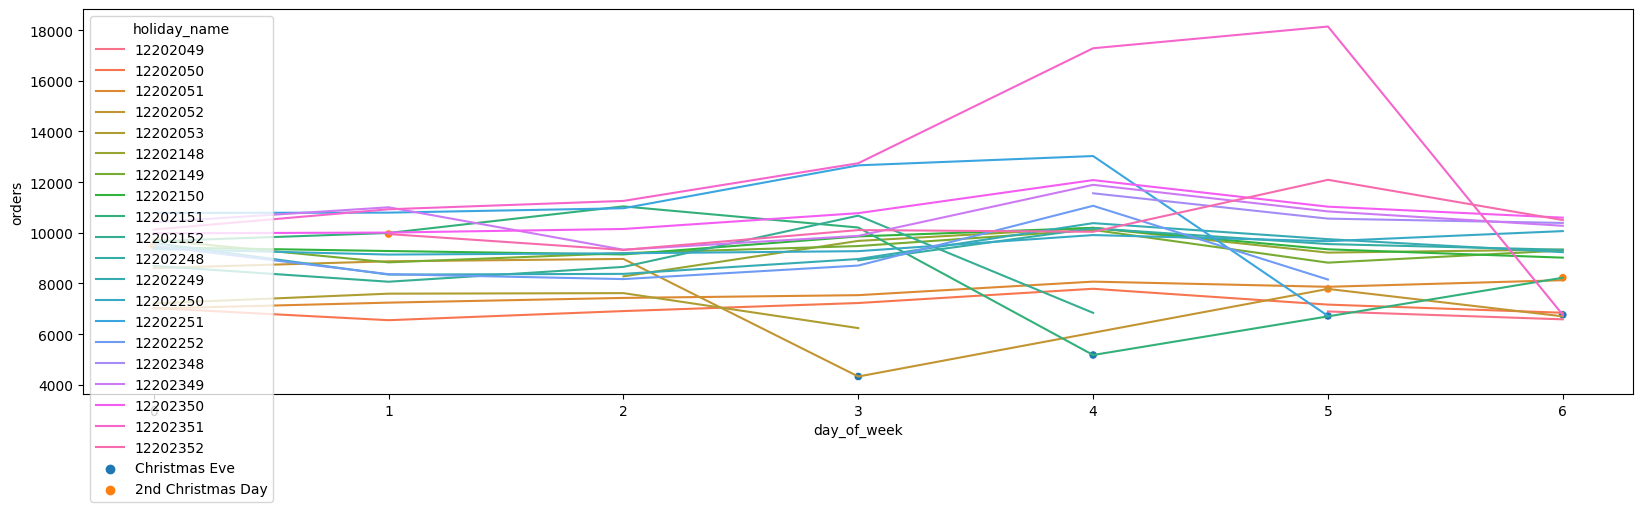

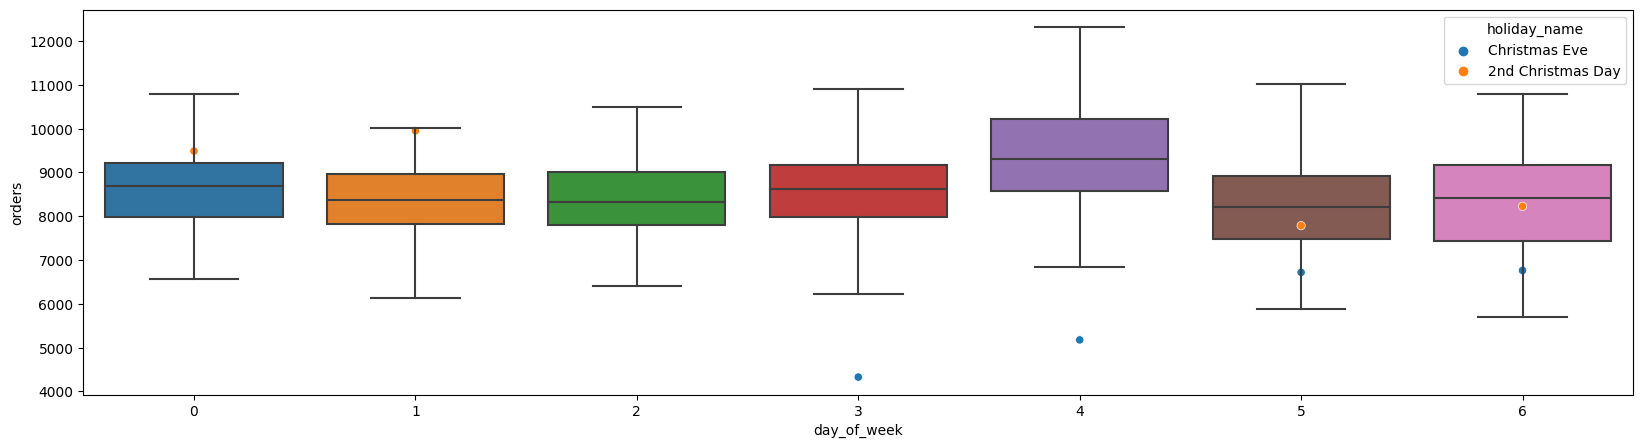

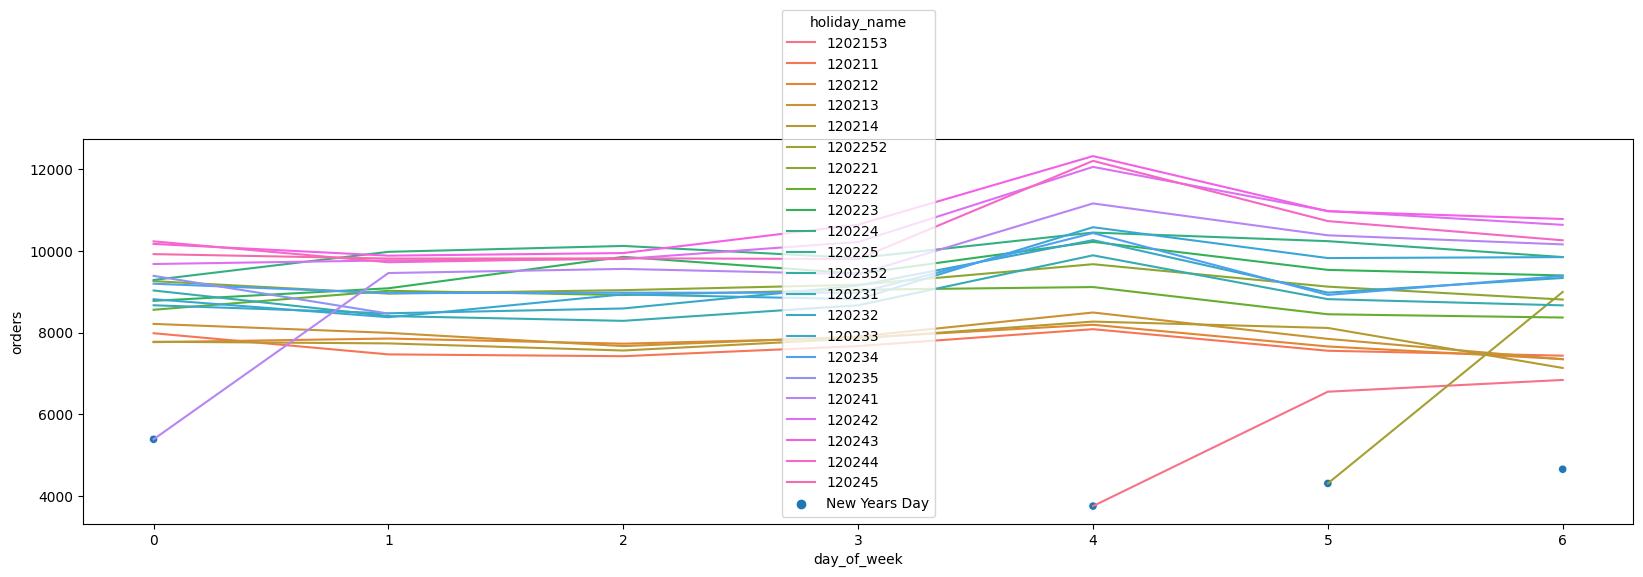

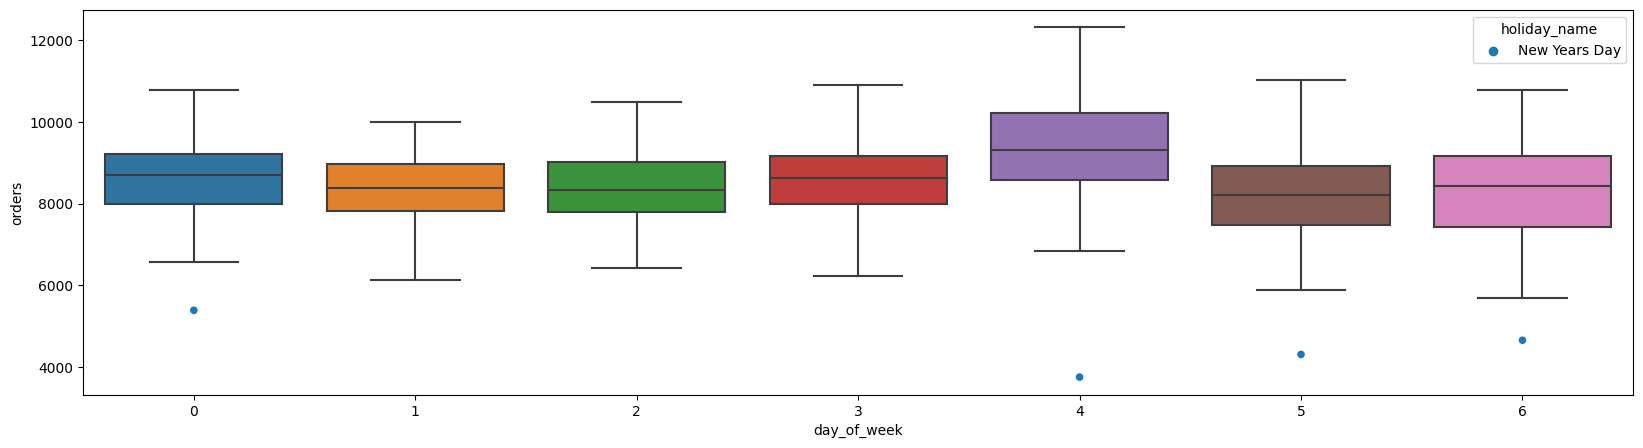

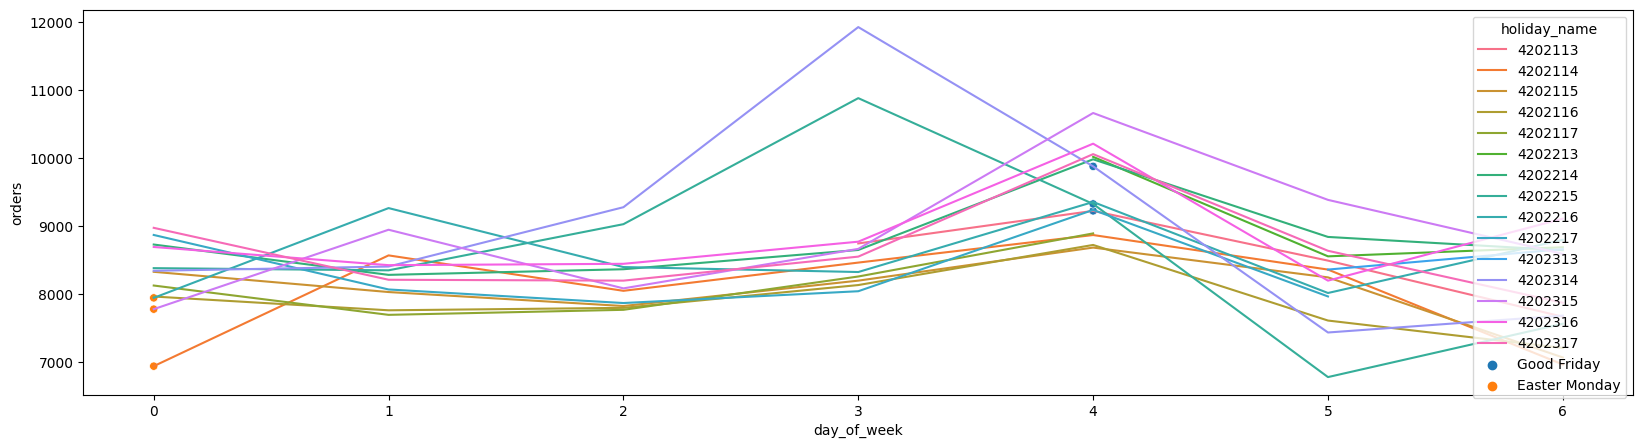

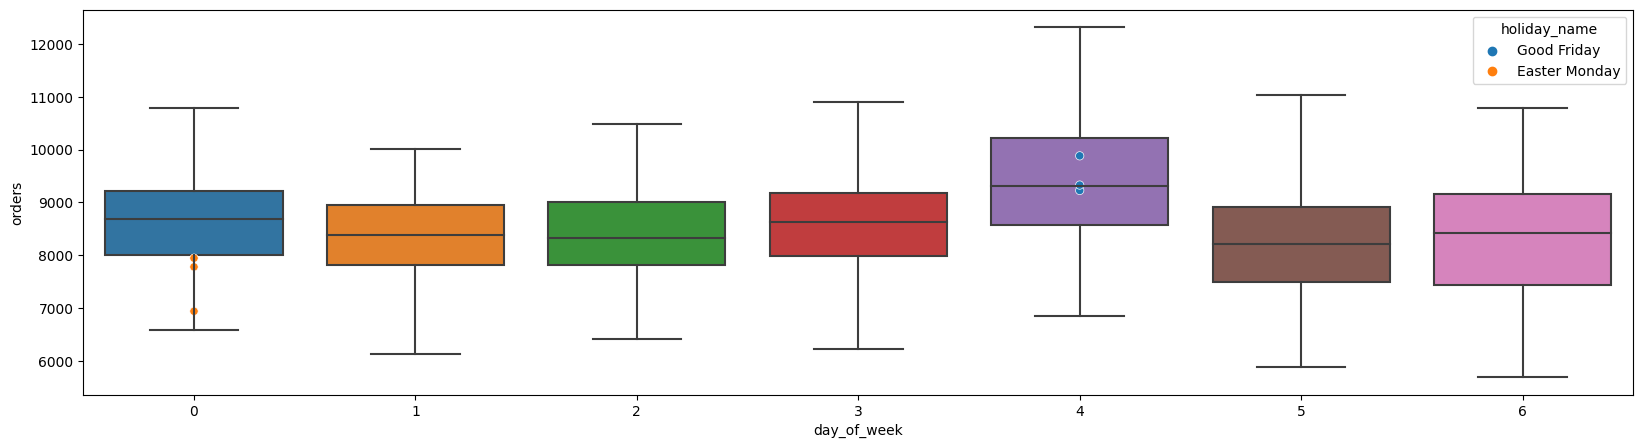

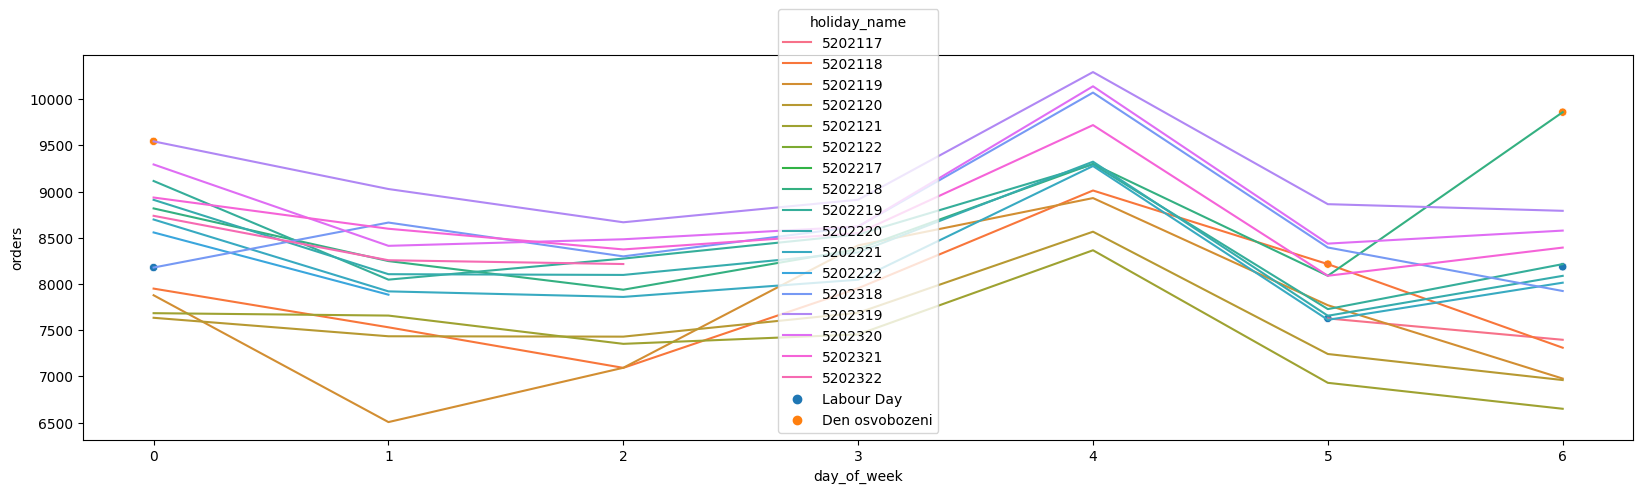

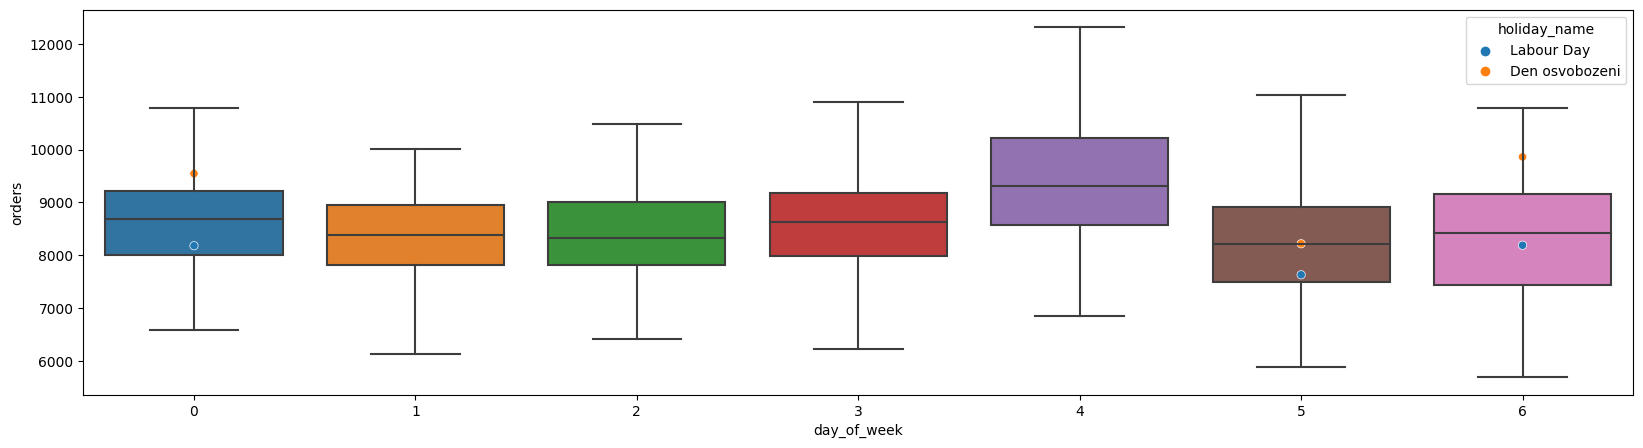

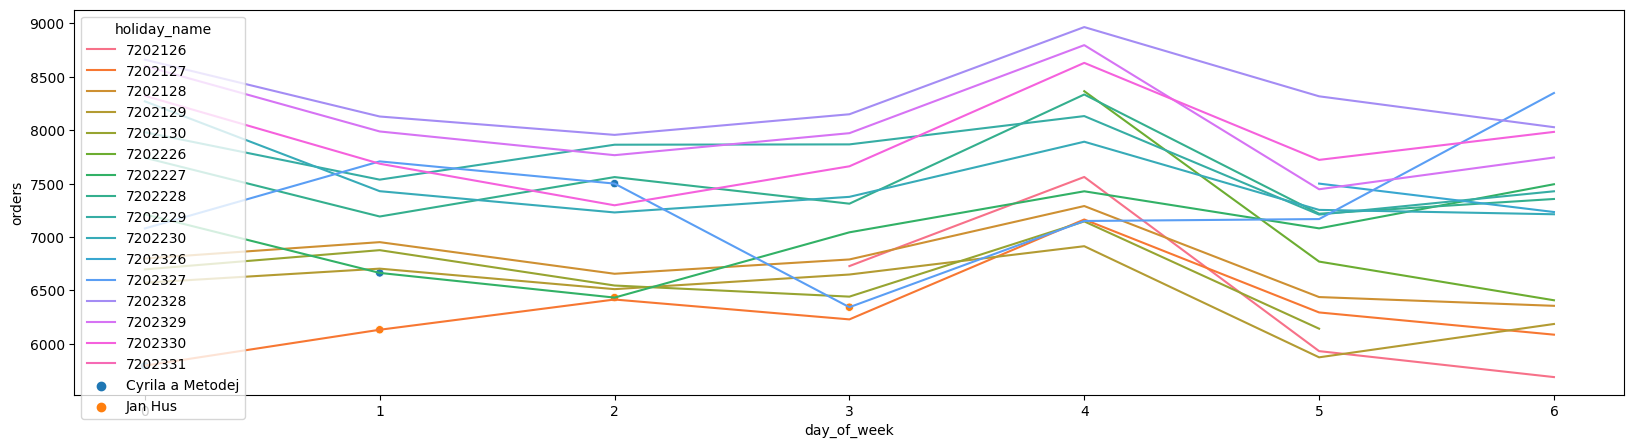

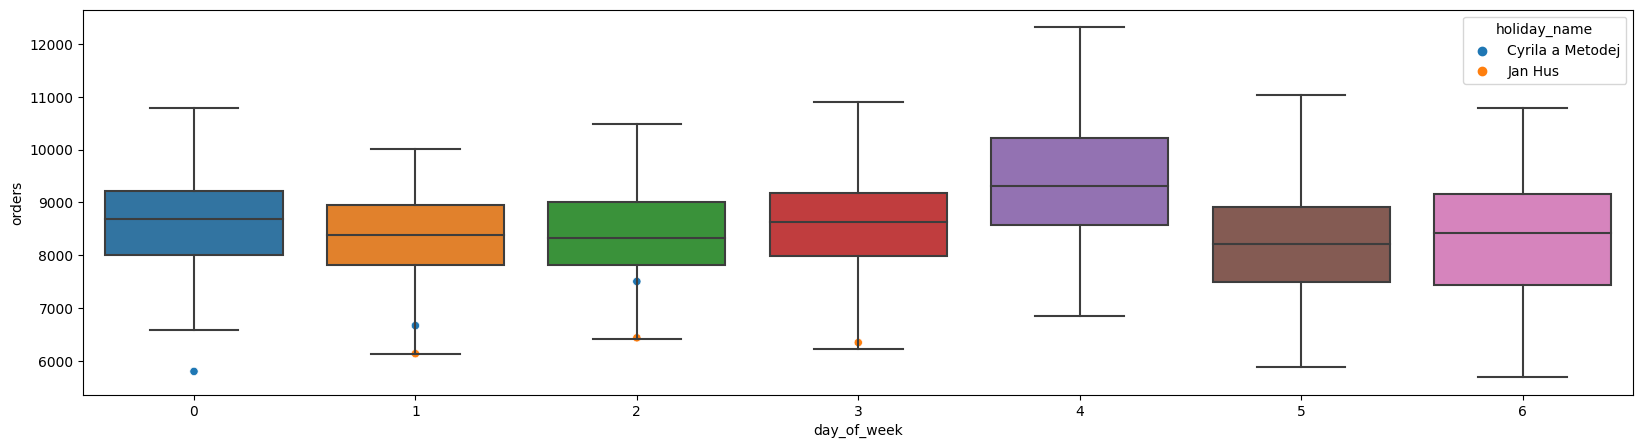

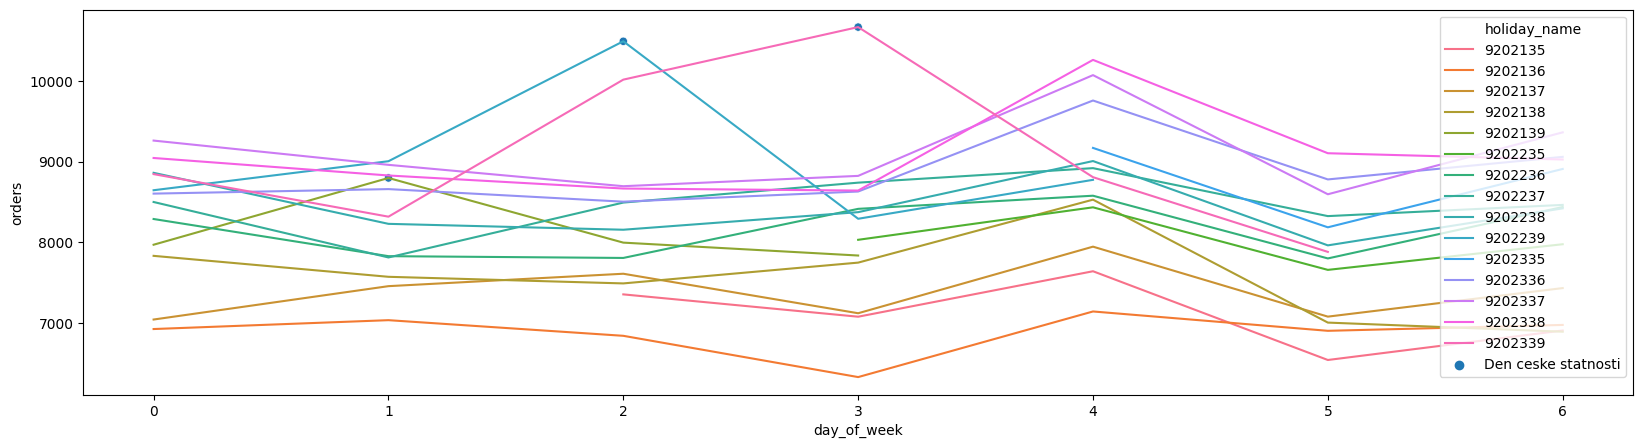

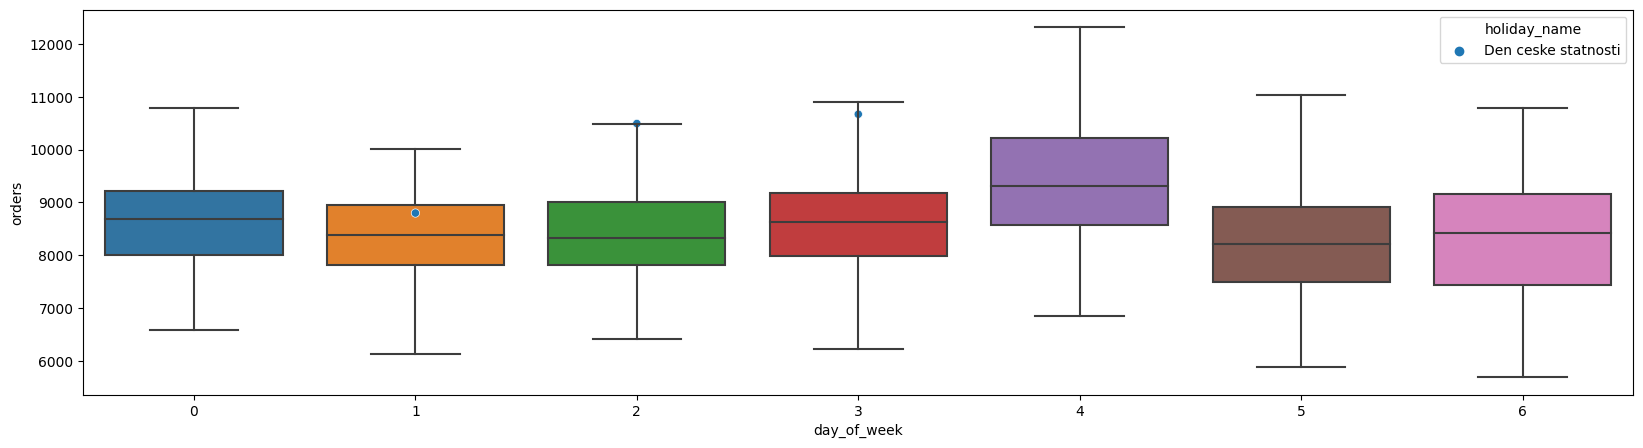

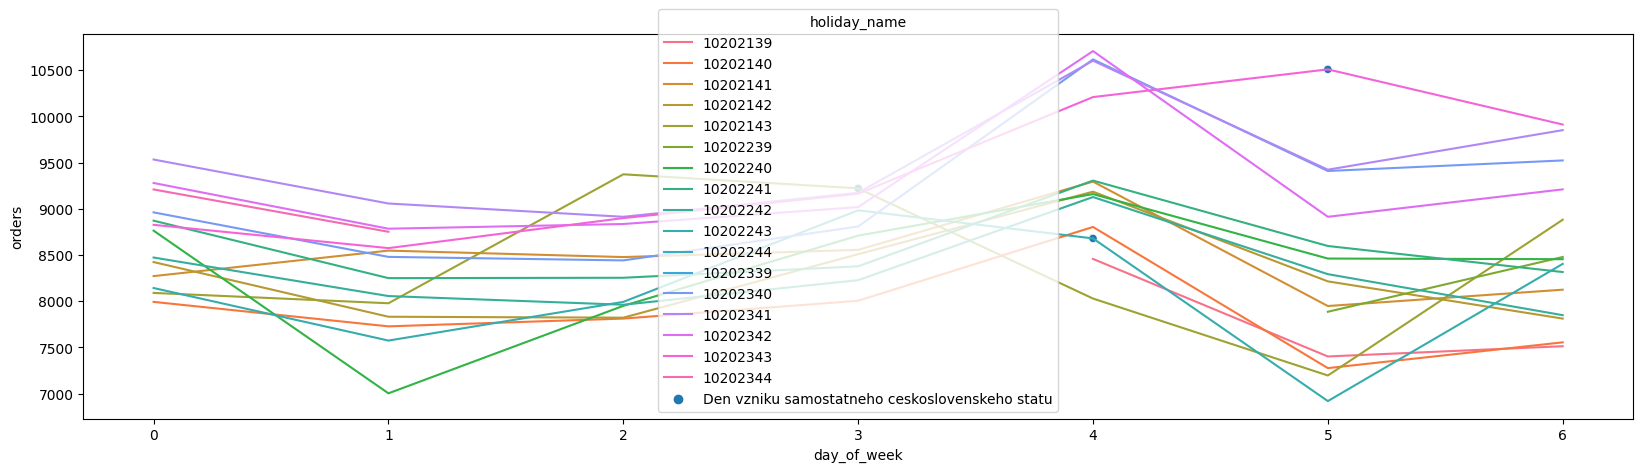

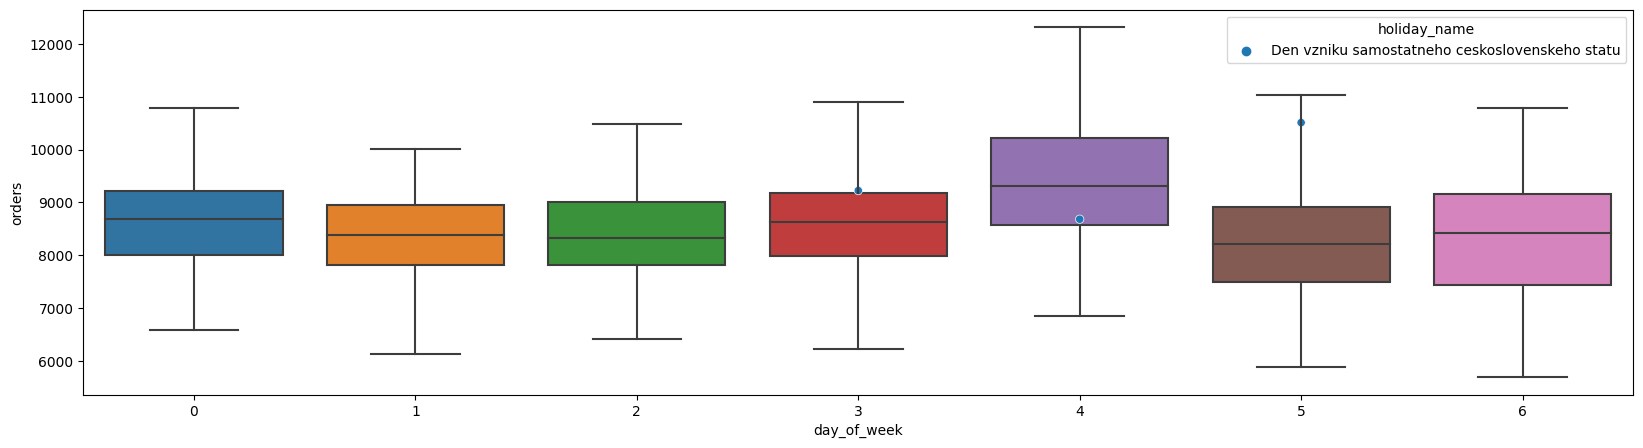

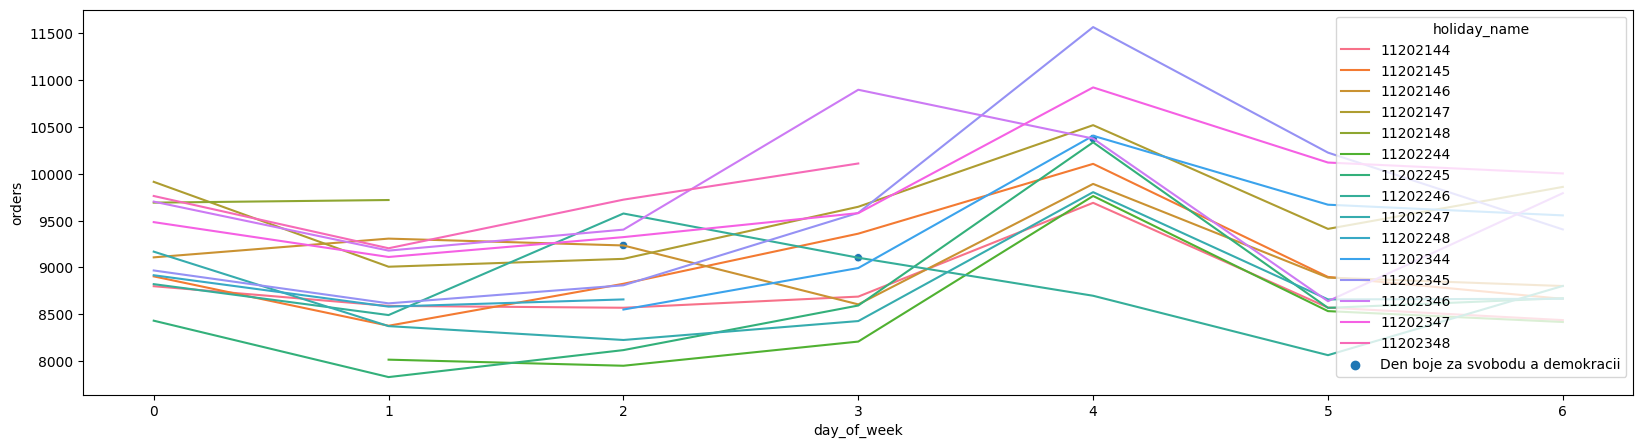

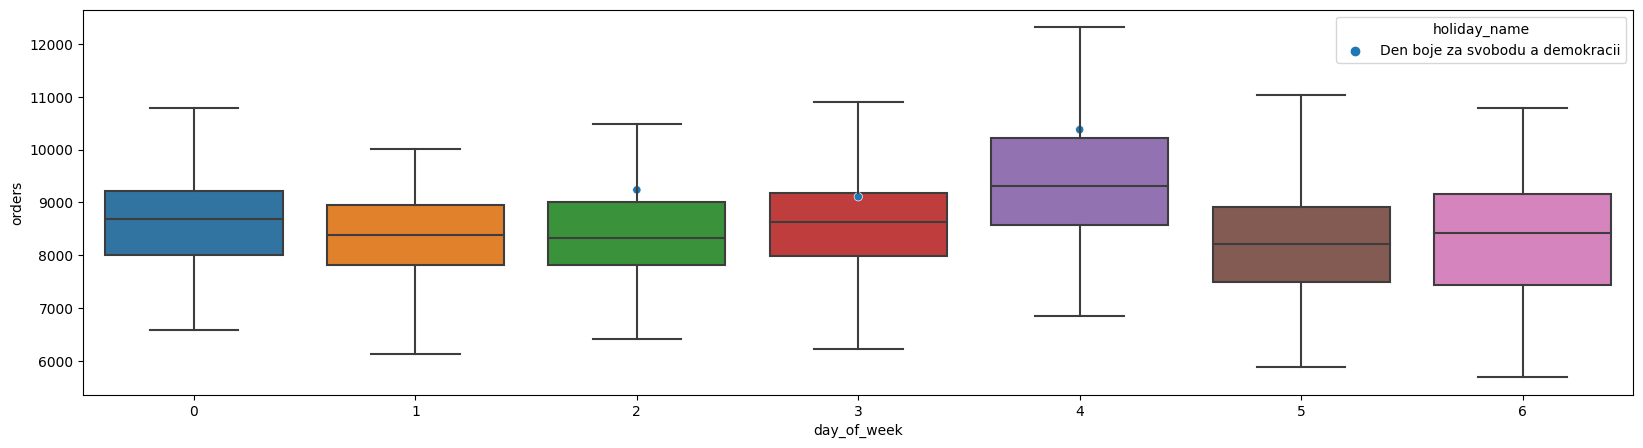

Brno_1


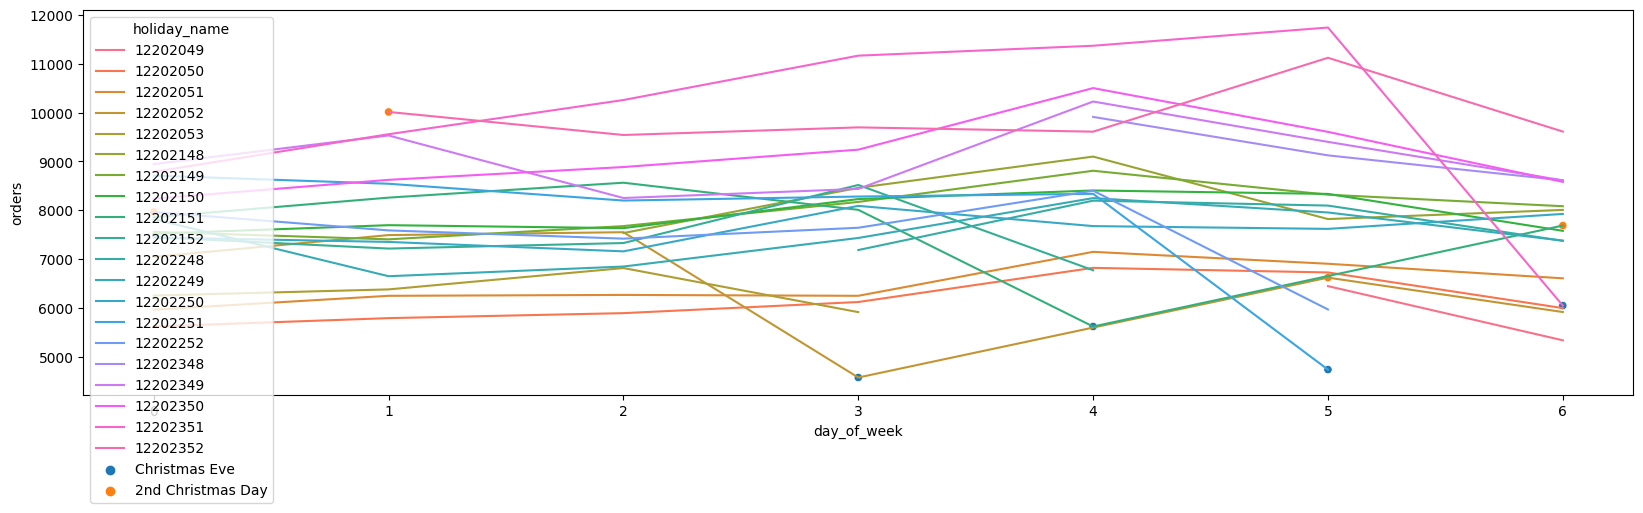

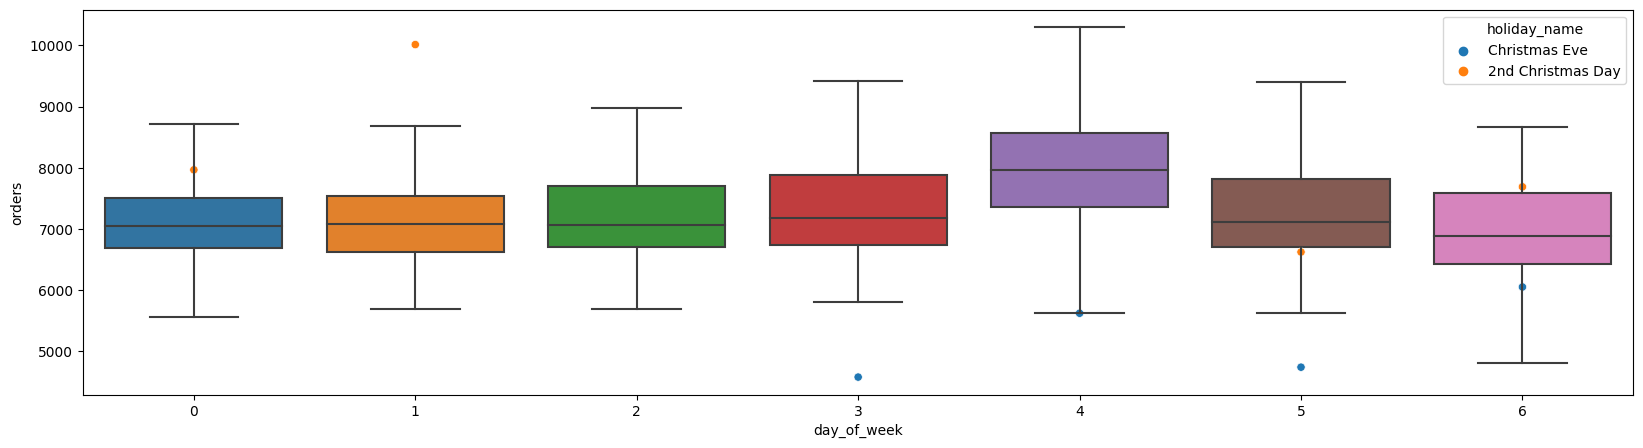

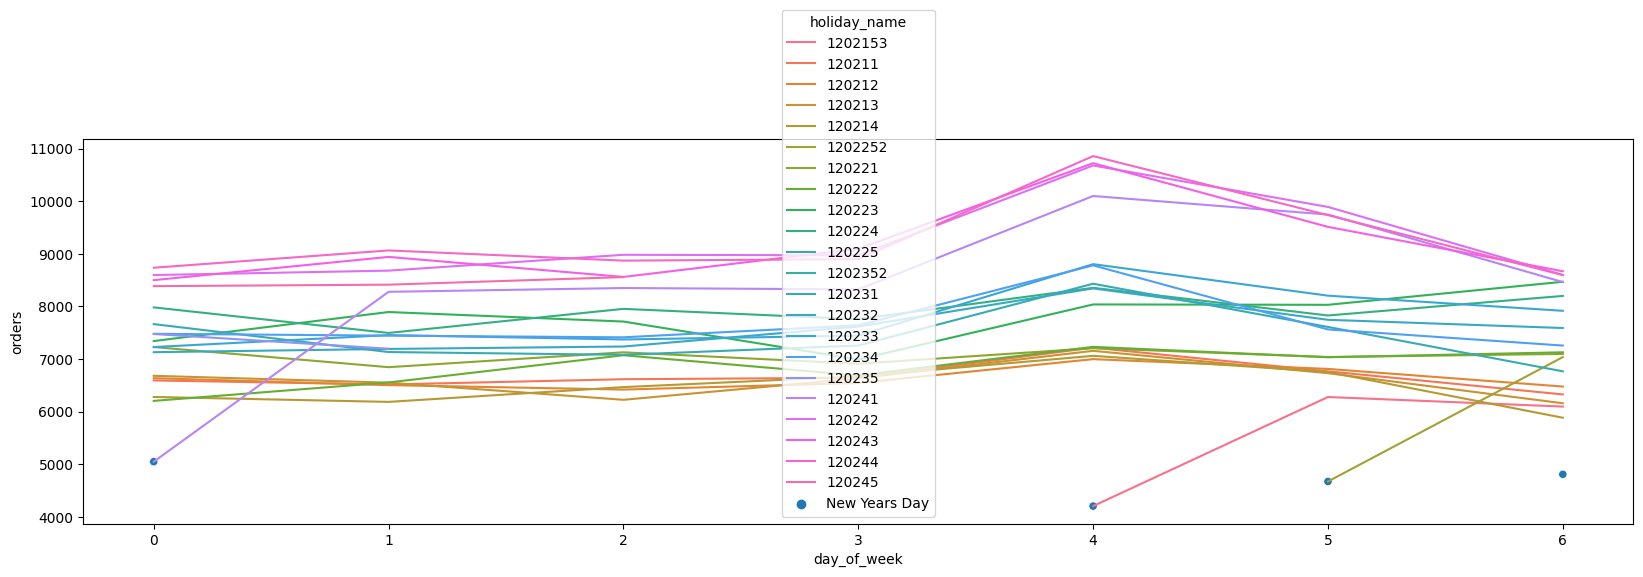

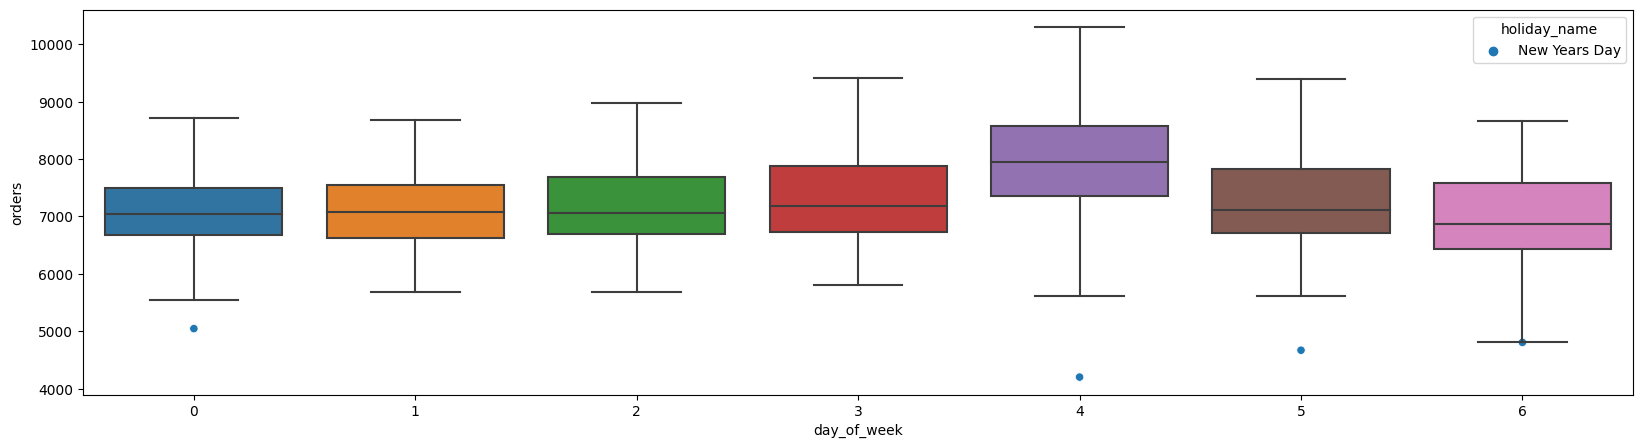

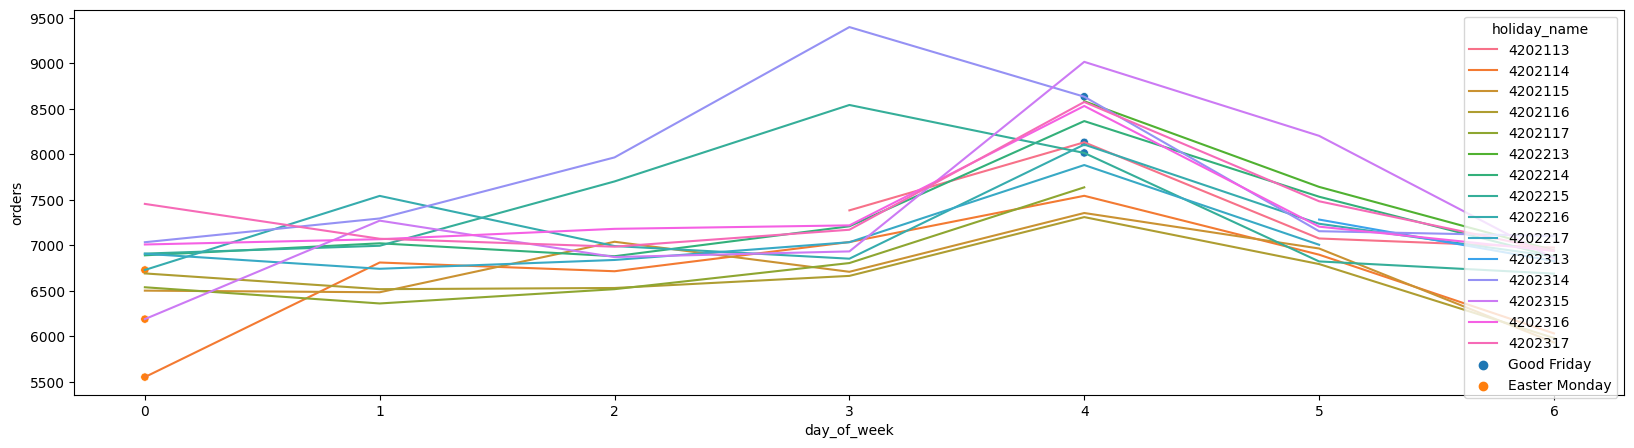

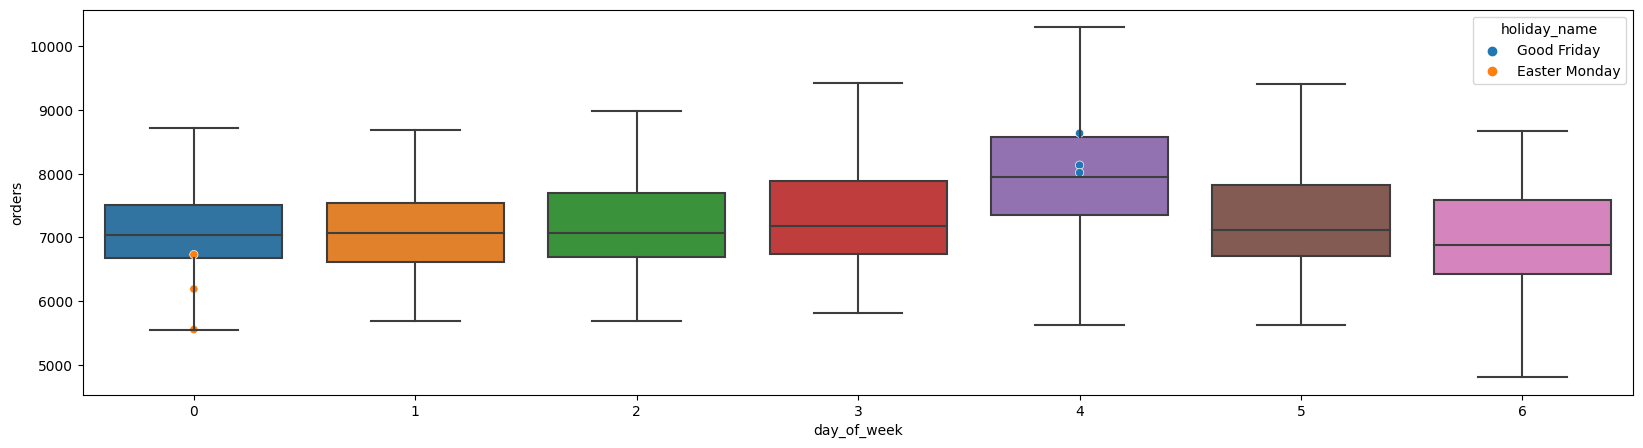

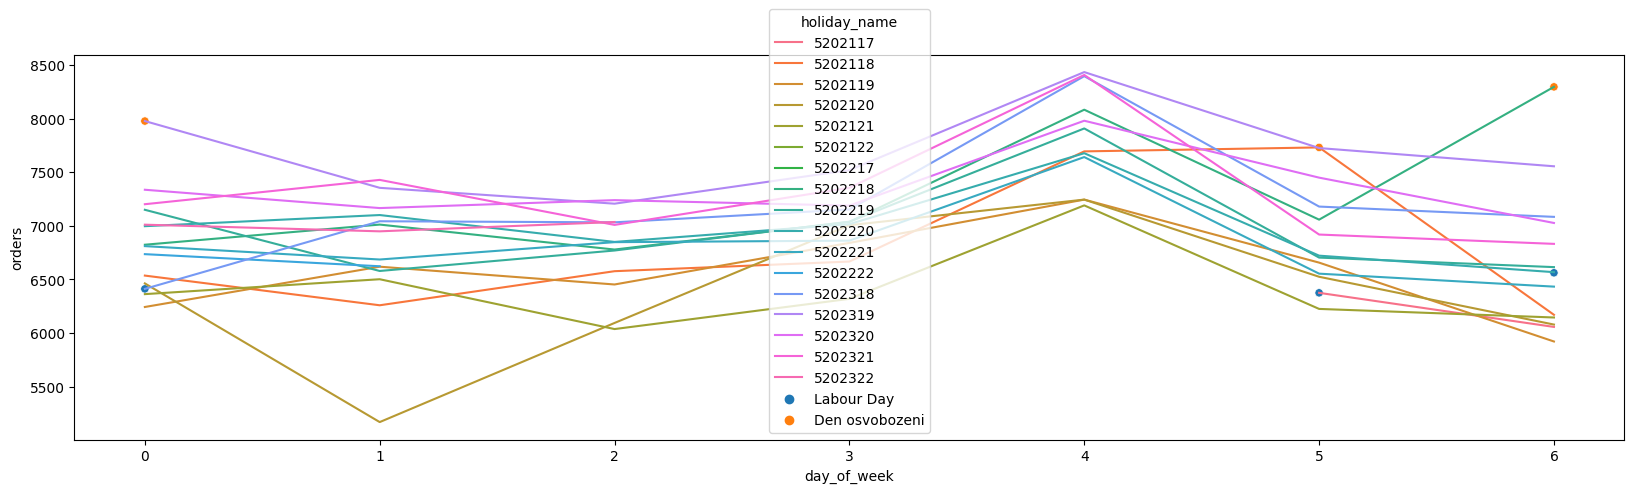

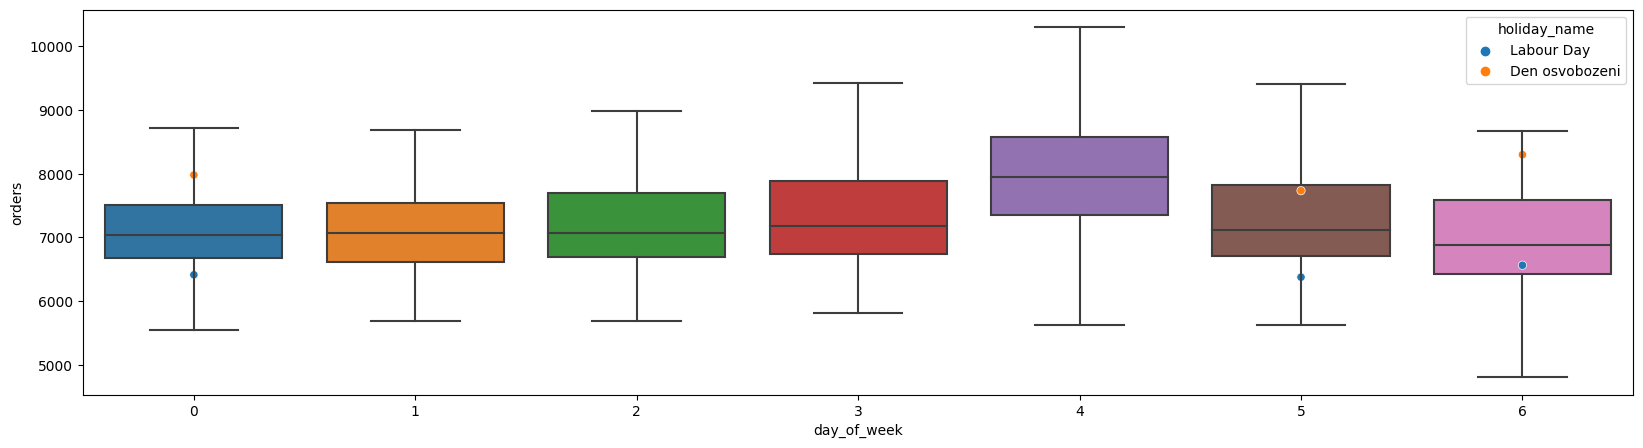

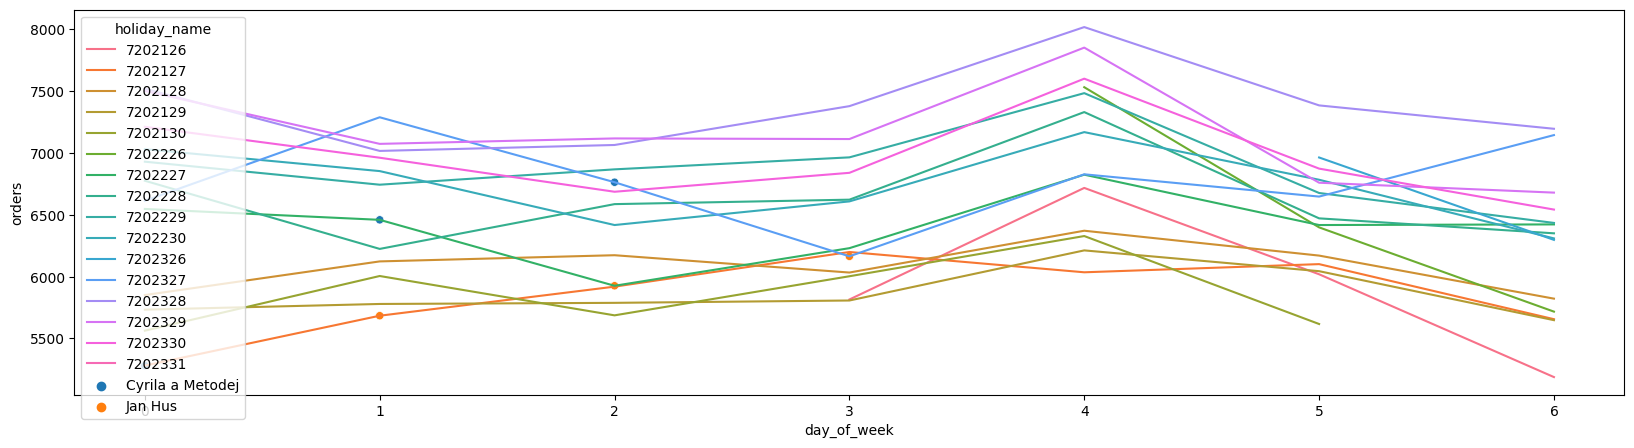

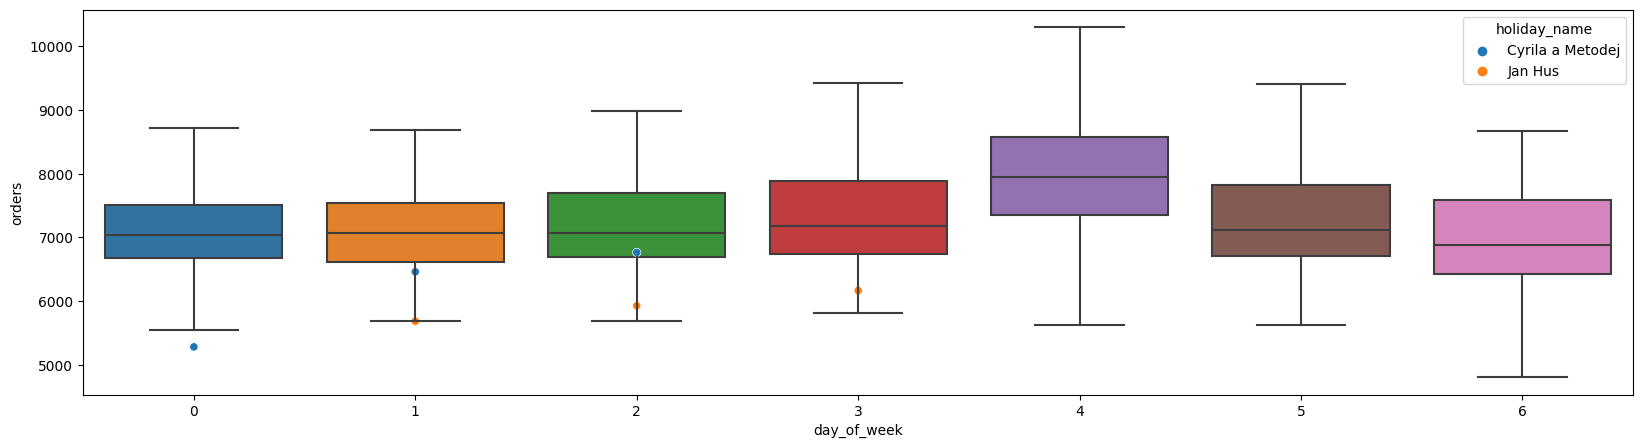

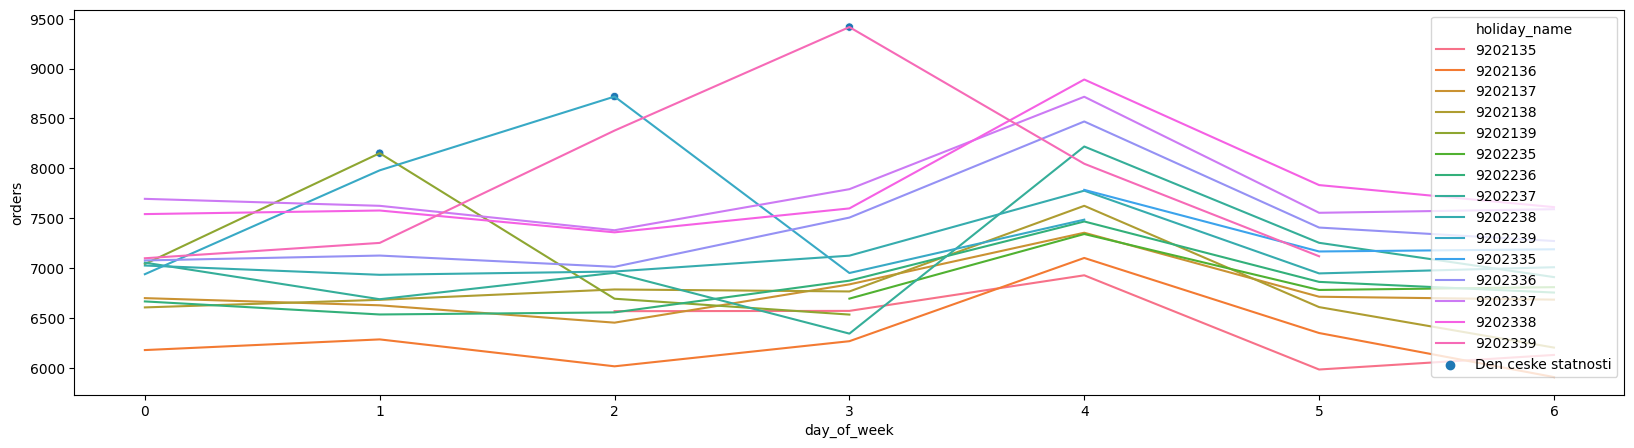

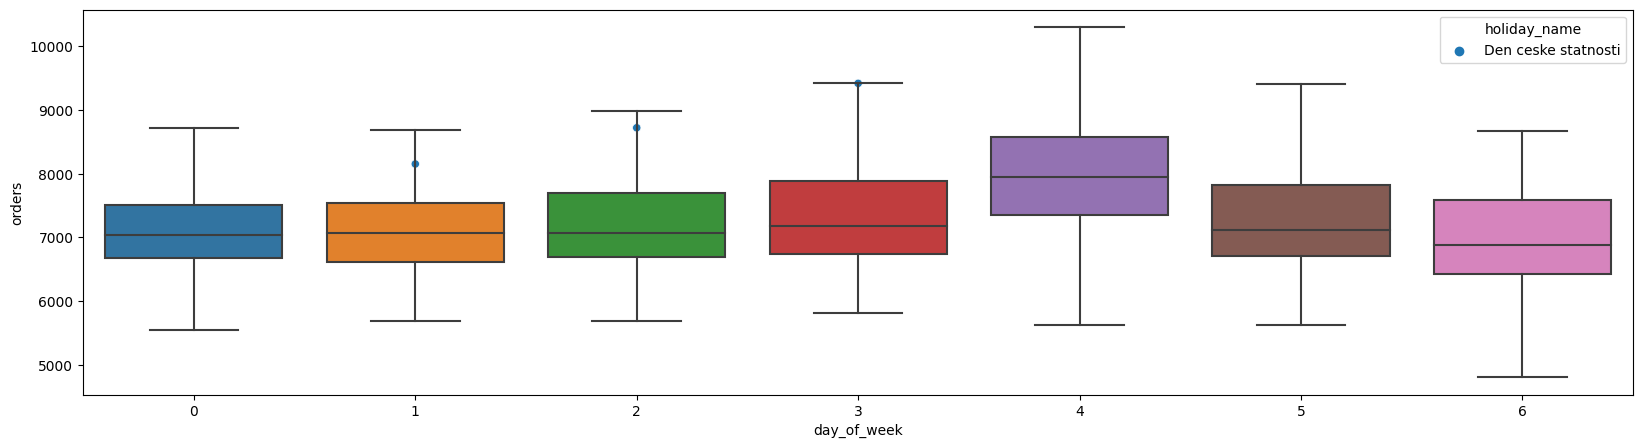

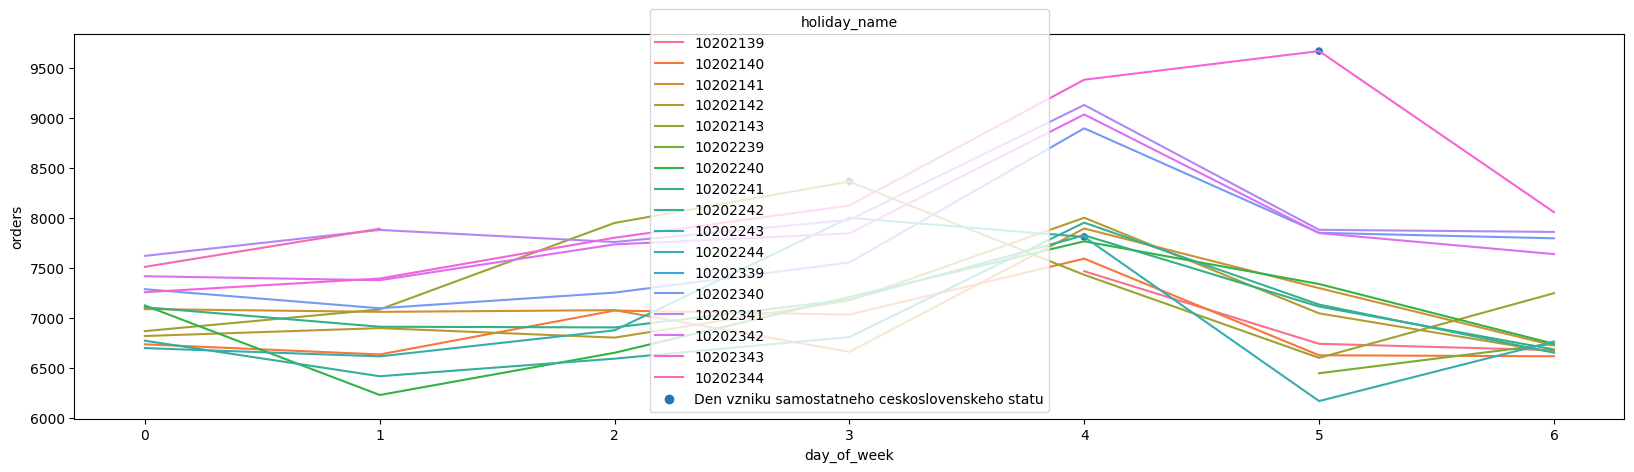

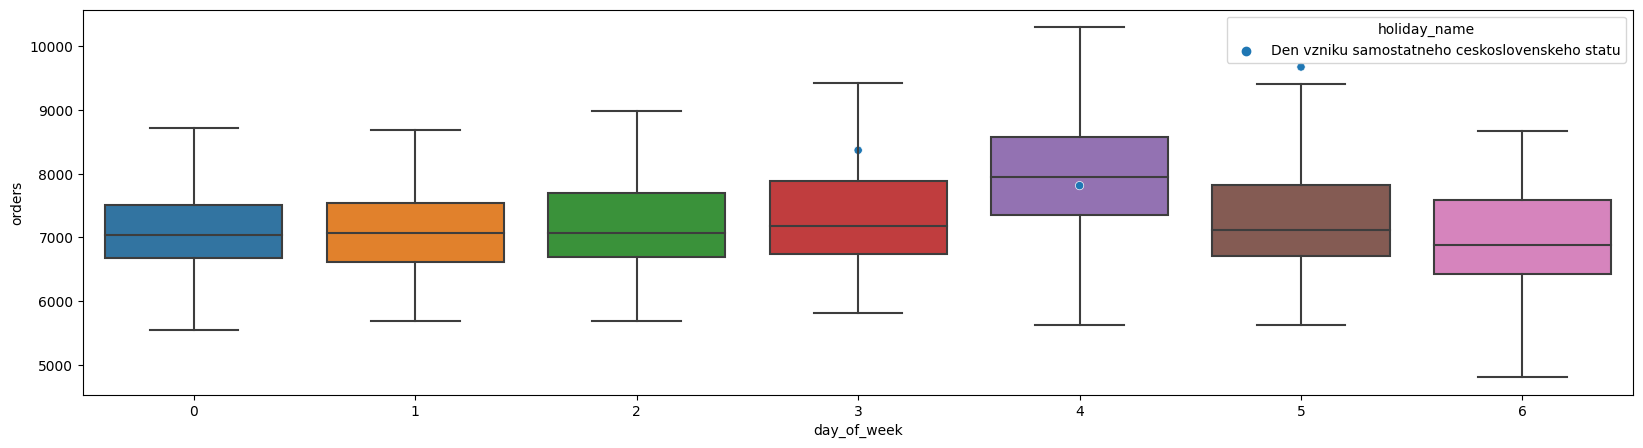

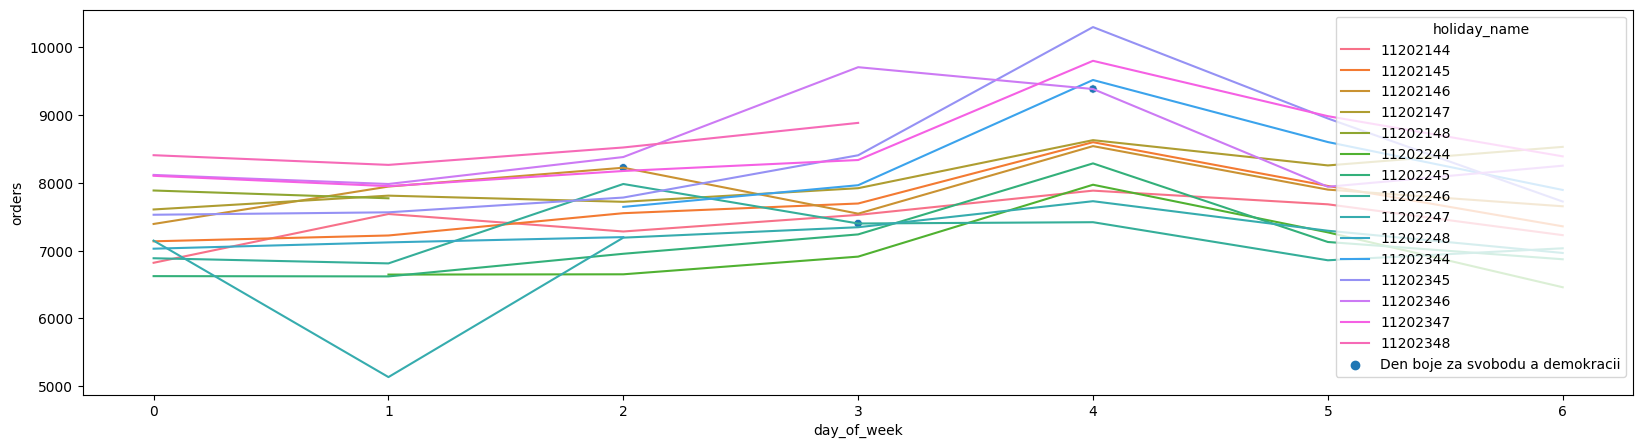

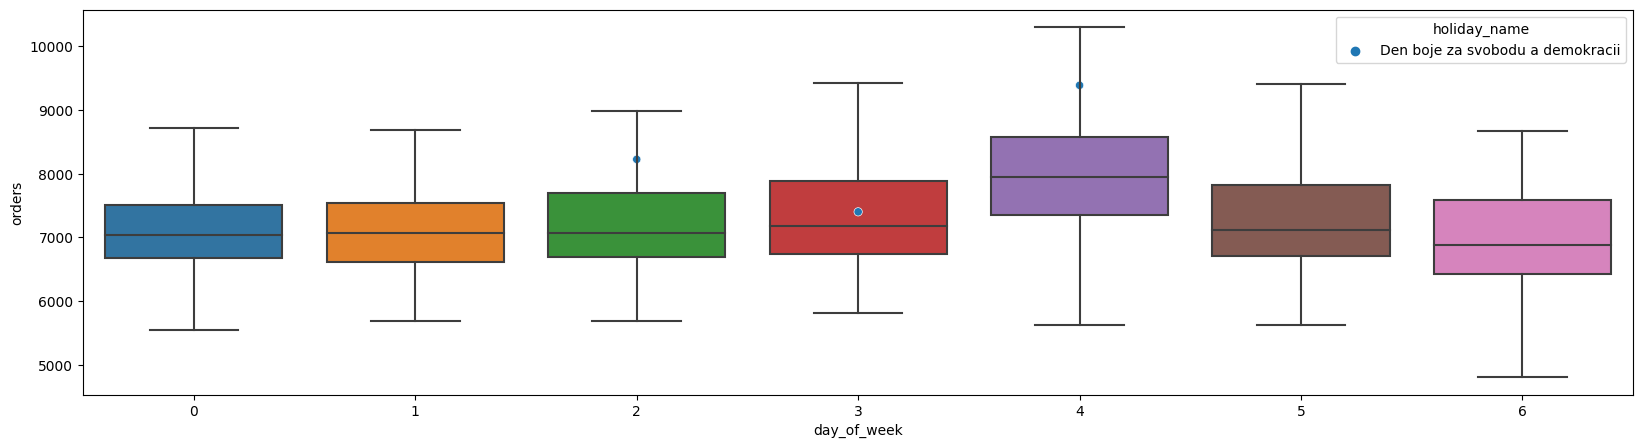

Prague_2


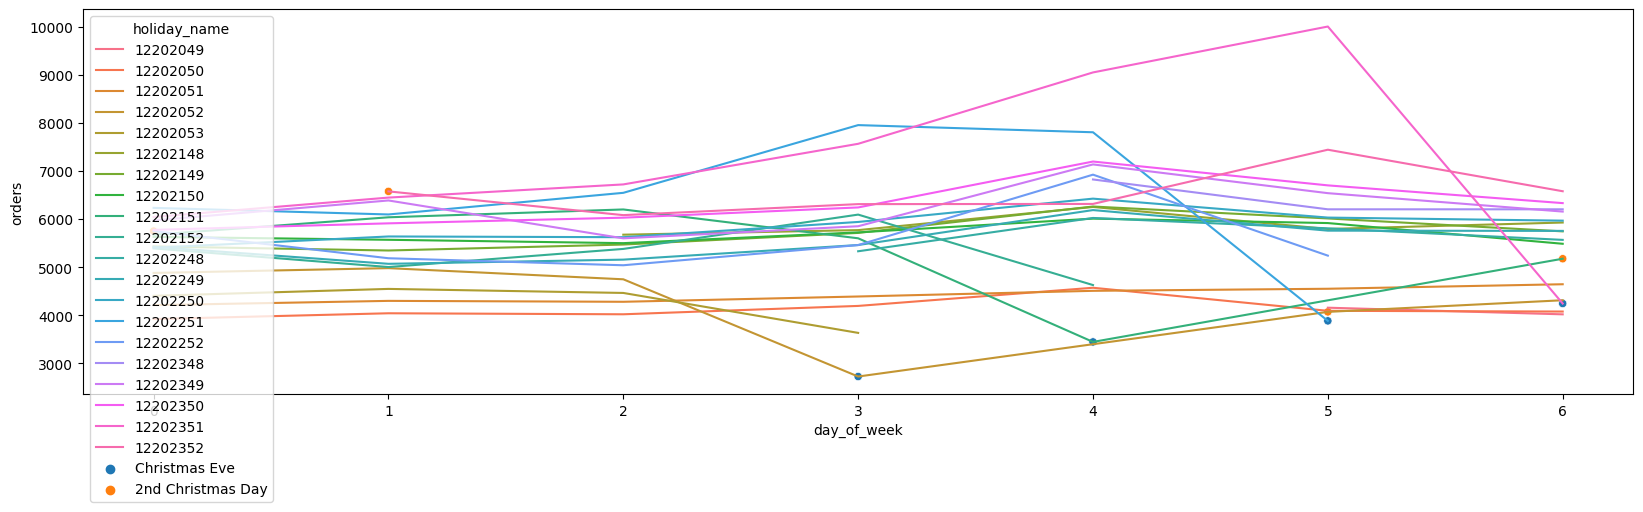

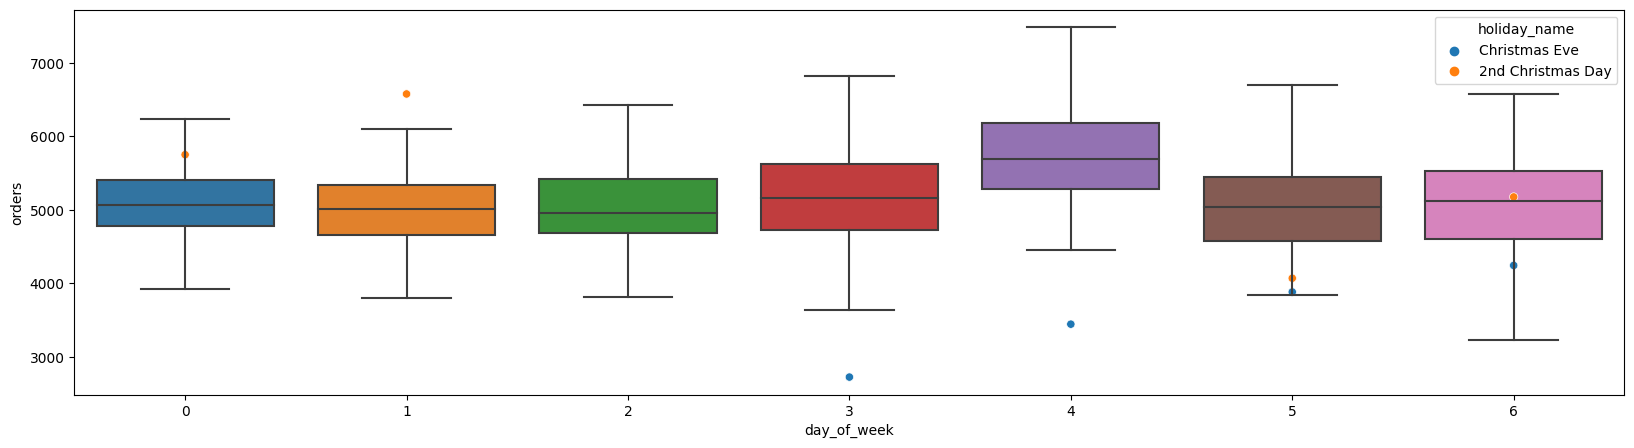

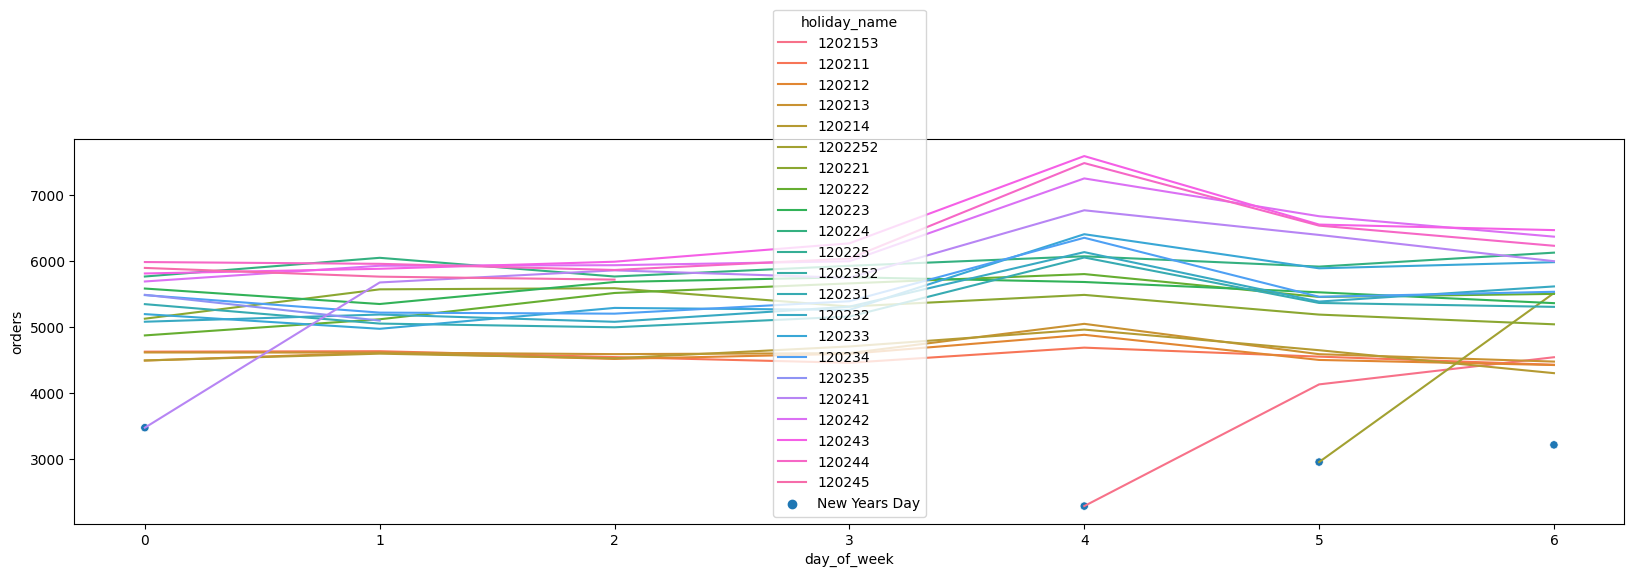

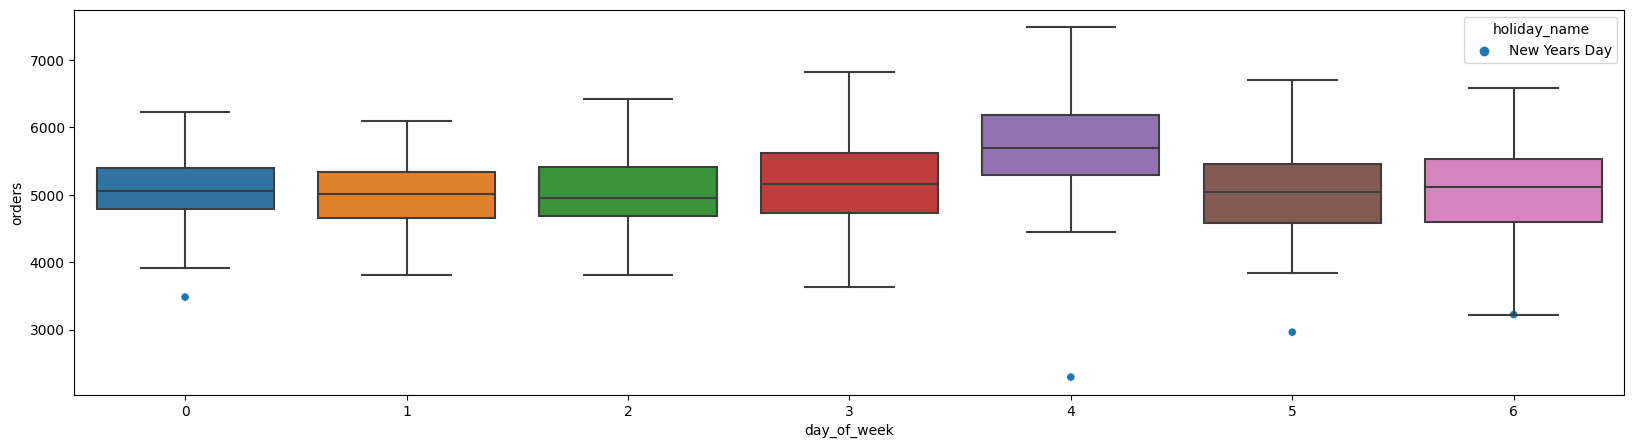

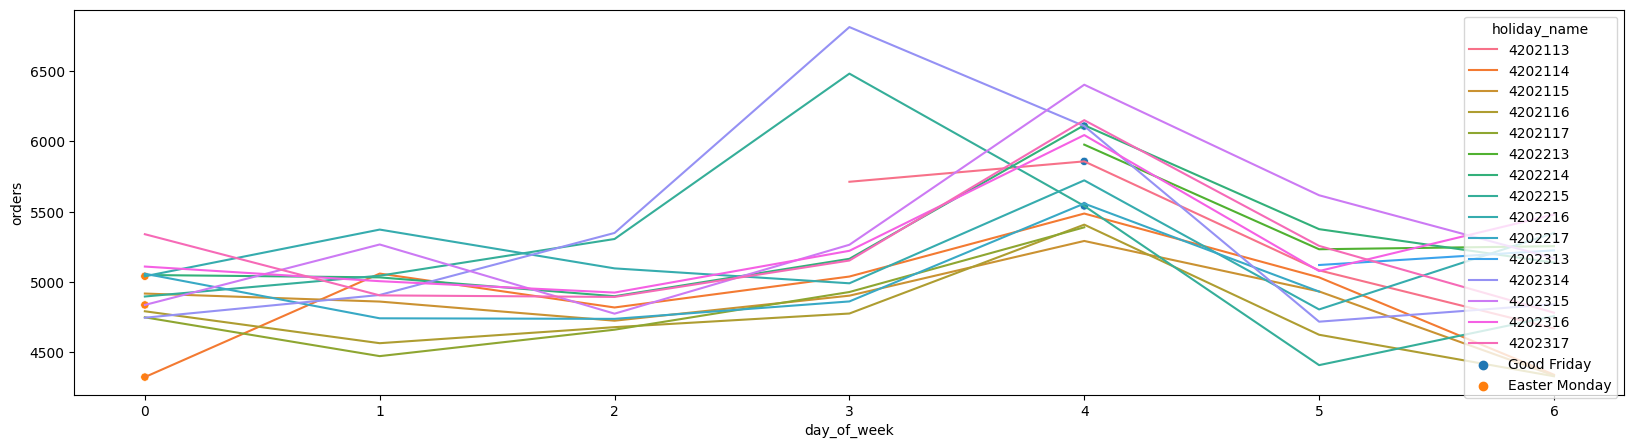

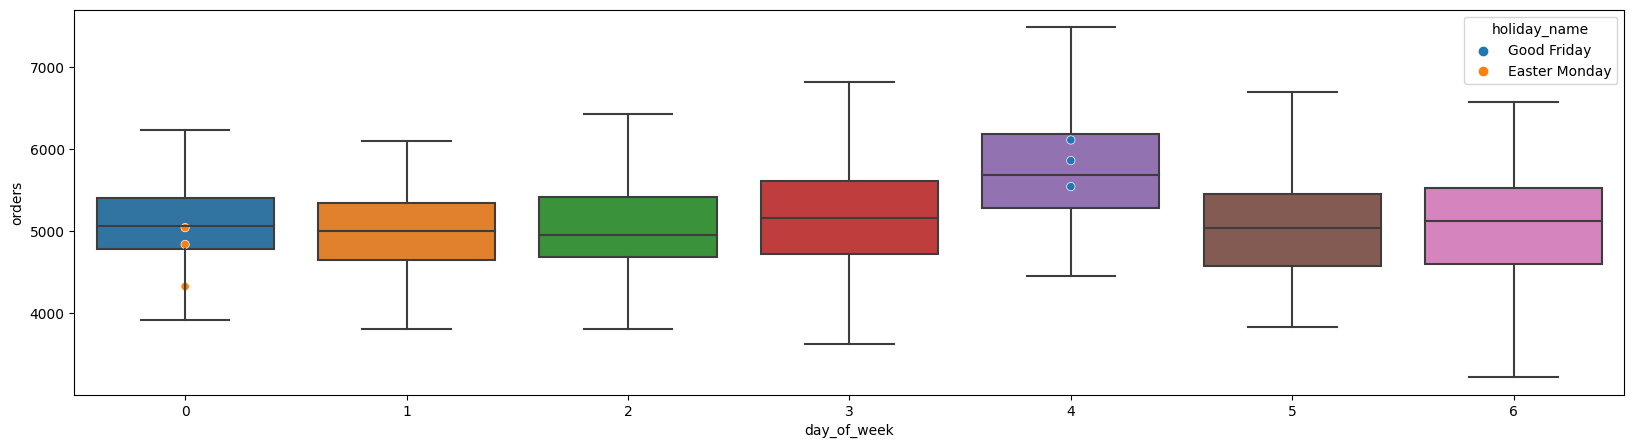

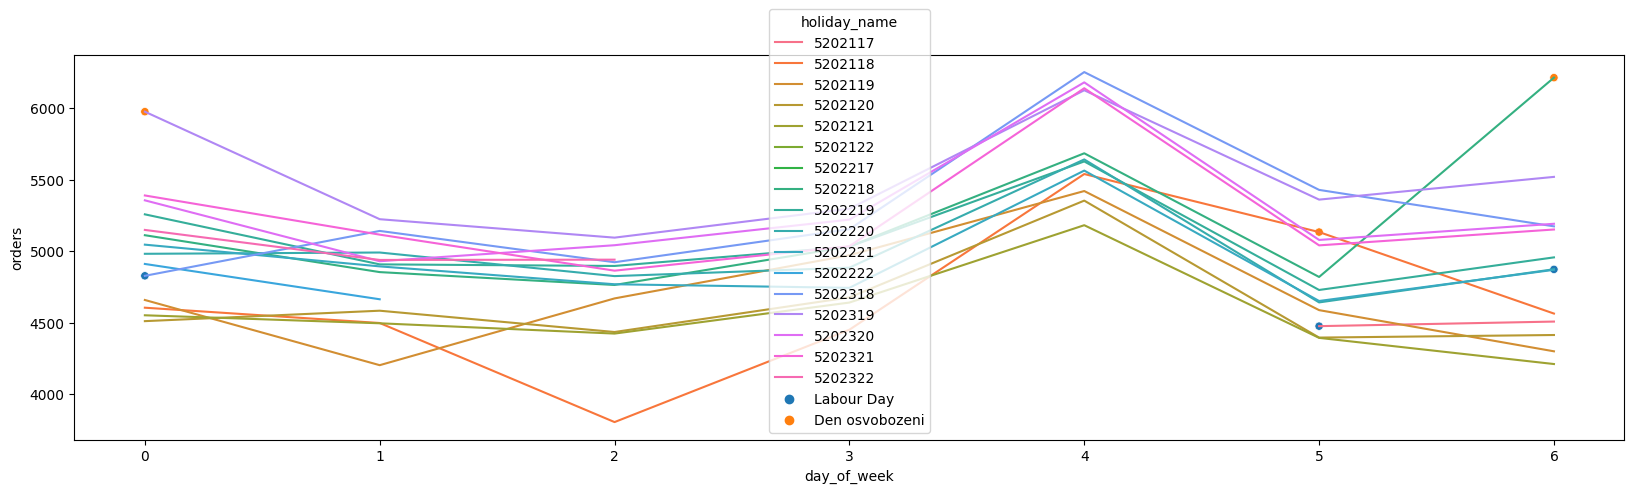

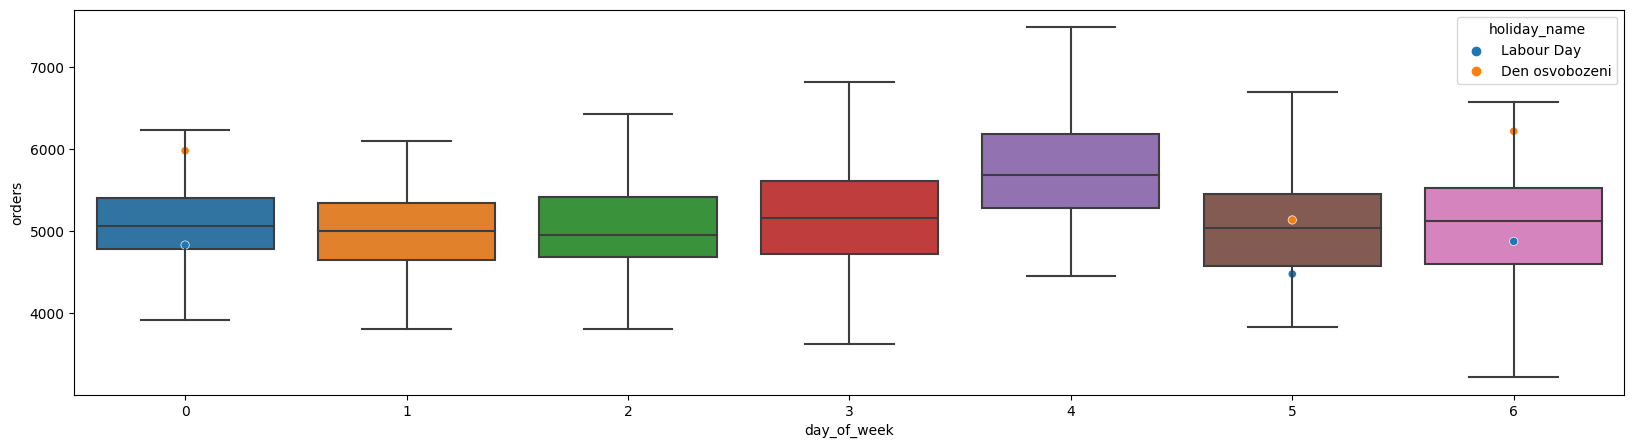

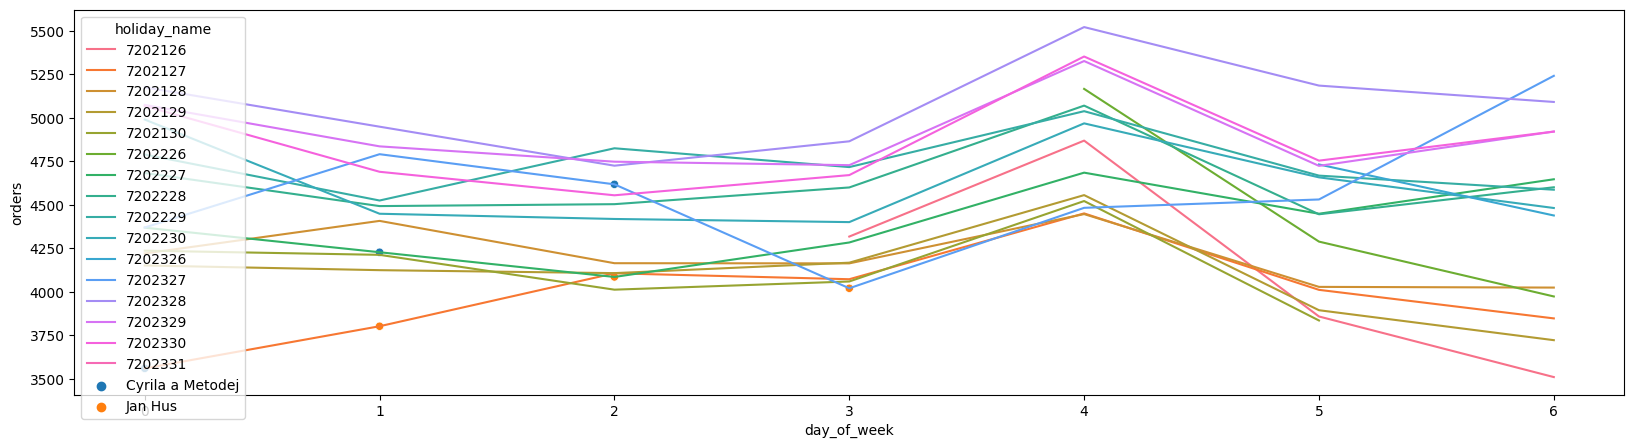

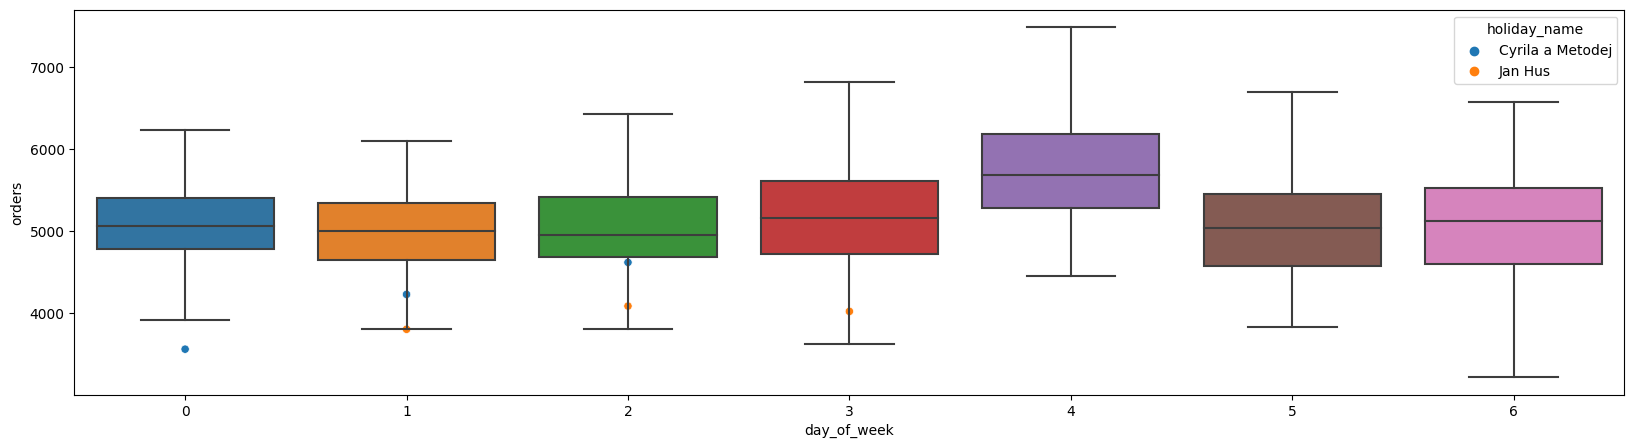

In [ ]:
for warehouse in train_data.warehouse.unique():
    df=df_holiday[(df_holiday.warehouse==warehouse)]
    df["year_month"]=df["month"].astype(str)+df['year'].astype(str)+df["week"].astype(str)
    print(warehouse)
    for month in df["month"].unique():
        df_month=df[df["month"]==month]
        fig,ax=plt.subplots(figsize=(20,5))
        sns.lineplot(df_month,x="day_of_week",y="orders",hue= df_month['year_month'].astype(str),ax=ax)
        df_month_holiday=df_month[df_month["holiday"]==1]
        sns.scatterplot(df_month_holiday,x="day_of_week",y="orders",ax=ax,hue='holiday_name')
        plt.show()
        fig,ax=plt.subplots(figsize=(20,5))
        sns.boxplot(df,x="day_of_week",y="orders",ax=ax,showfliers=False)
        df_month_holiday=df_month[df_month["holiday"]==1]
        sns.scatterplot(df_month_holiday,x="day_of_week",y="orders",ax=ax,hue='holiday_name')
        plt.show()
        
  

In [ ]:
test_data.dtypes

#### Effect of shop closed
-the effect of shop closed and holidays look same


In [ ]:
for warehouse in train_data.warehouse.unique():
    df=train_data[(train_data.warehouse==warehouse)]
   
    print(warehouse)
    fig,ax=plt.subplots(figsize=(25,5))
    sns.boxplot(df,x='month',y='orders',ax=ax,showfliers=False)
    df_shops_closed=df[df['shops_closed' ]==1]
   
    sns.scatterplot(df_shops_closed,x=df_shops_closed['month']-1,y='orders',hue='holiday_name')
 
    plt.show()

#### Effect of winter_school_holidays

In [ ]:
for warehouse in train_data.warehouse.unique():
    df=train_data[(train_data.warehouse==warehouse)]
   
    print(warehouse)
    fig,ax=plt.subplots(figsize=(25,5))
    sns.boxplot(df,x='month',y='orders',ax=ax,showfliers=False)
    plt.title("orders by month and winter school days")
    df_winter_school_holidays=df[df['winter_school_holidays' ]==1]
    sns.scatterplot(df_winter_school_holidays,x=df_winter_school_holidays['month']-1,y='orders',ax=ax,hue=df_winter_school_holidays['year'].astype(str))
    plt.show()
    fig,ax=plt.subplots(figsize=(25,5))
    sns.scatterplot(df_winter_school_holidays,x="date",y='orders',ax=ax,hue='month')
    
    plt.show()

There are  outliers during winter holidays, but its all scattered. With the above plot we are not really able to tell how school_holidays are affecting sales. Now Let's explore below questions.
- is first day of school holiday is different from last of school holiday?
- compare with same day in different week, egg - monday with month in same month

In [ ]:
for warehouse in train_data.warehouse.unique():
    df=train_data[(train_data.warehouse==warehouse)]
   
    print(warehouse)
    
    df_winter_school_holidays=df[df['winter_school_holidays' ]==1]
    df_non_winter_school_holidays=df[~df['winter_school_holidays' ]==1]
    df_winter_school_holidays_start_date=df_winter_school_holidays[["warehouse","year","date"]].groupby(["warehouse","year"]).agg(start_date=('date','min'))
    df_winter_school_holidays=df_winter_school_holidays_start_date.merge( df_winter_school_holidays,on=["warehouse","year"],how='left')
    df_winter_school_holidays['day_number']=(df_winter_school_holidays["date"]-df_winter_school_holidays["start_date"])+timedelta(days=1)
    month_year=df_winter_school_holidays[["month","year"]].drop_duplicates()
    df_all_weeks=pd.DataFrame(df.columns)
    for month,year in  month_year.itertuples(index=False):
        df_date=df_non_winter_school_holidays[(df_non_winter_school_holidays.month==month)&(df_non_winter_school_holidays.year==year)]
        df_all_weeks=pd.concat([ df_all_weeks,df_date])
    df_all_weeks['day_number']=timedelta(days=0)
    df_analysis=pd.concat([ df_all_weeks,df_winter_school_holidays]).sort_values(by='date')
    fig,ax=plt.subplots(figsize=(20,10))
    df_analysis.boxplot('orders',by='day_of_week',ax=ax)
    plt.show()
    fig,ax=plt.subplots(figsize=(20,10))
    sns.scatterplot( df_winter_school_holidays,x='day_of_week',y='orders',hue='day_number')
    plt.show()
   
    
  

In [ ]:
for warehouse in train_data.warehouse.unique():
    df=train_data[(train_data.warehouse==warehouse)]
   
    print(warehouse)
    fig,ax=plt.subplots(figsize=(25,5))
    sns.boxplot(df,x='month',y='orders',ax=ax,showfliers=False)
    plt.title("orders by month and winter school days")
    df_winter_school_holidays=df[df['winter_school_holidays' ]==1]
    sns.scatterplot(df_winter_school_holidays,x=df_winter_school_holidays['month']-1,y='orders',ax=ax,hue=df_winter_school_holidays['year'].astype(str))
    plt.show()
    fig,ax=plt.subplots(figsize=(25,5))
    sns.scatterplot(df_winter_school_holidays,x="date",y='orders',ax=ax,hue='month')
    
    plt.show()

In [ ]:
for warehouse in train_data.warehouse.unique():
    df=train_data[(train_data.warehouse==warehouse)]
   
    print(warehouse)
    fig,ax=plt.subplots(figsize=(25,5))
    sns.boxplot(df,x='month',y='orders',ax=ax,showfliers=False)
    df_school_holidays=df[df['school_holidays' ]==1]
    plt.show()
    fig,ax=plt.subplots(figsize=(25,5))
    
    sns.scatterplot(df_school_holidays,x='month',y='orders',ax=ax)
 
    plt.show()

### Outlier analysis

In [ ]:
fig,ax=plt.subplots(figsize=(25,7))
train_data.boxplot('orders',by='warehouse',ax=ax)

In [ ]:
def find_outliers_iqr(df, column, threshold=1.5):
    """
    Identifies outliers in a DataFrame column using the IQR method.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The name of the column to check for outliers.
    threshold (float): The multiplication factor for the IQR.

    Returns:
    pd.DataFrame: A DataFrame containing the outliers.
    """

    # Calculate the IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)

    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return outliers

In [ ]:
for warehouse in train_data.warehouse.unique():
    df=train_data[(train_data.warehouse==warehouse)]
    
    df_outliers=find_outliers_iqr(df,'orders')
    print(f"number of ouliers in {warehouse} : {df_outliers.shape[0]}")
    